In [3]:
# --------------------------------------
# NYC Taxi Data Analysis with Sparklyr
# --------------------------------------

# **1. Setup Environment**
# -------------------------
install.packages(c("sparklyr", "dplyr", "ggplot2", "httr", "jsonlite", "tidyr"))
library(sparklyr)
library(dplyr)
library(ggplot2)
library(httr)
library(jsonlite)
library(tidyr)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘config’, ‘globals’



Attaching package: ‘sparklyr’


The following object is masked from ‘package:stats’:

    filter



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [32]:
# Initialize Spark
spark_install(version = "3.0")
sc <- spark_connect(master = "local")

In [35]:

# **2. Load Data from NYC Open Data API**
# ---------------------------------------
taxi_data_url <- "https://data.cityofnewyork.us/resource/2upf-qytp.json?$limit=100000"
taxi_data_json <- GET(taxi_data_url)
taxi_data_raw <- fromJSON(content(taxi_data_json, "text"), flatten = TRUE)
taxi_spark <- copy_to(sc, taxi_data_raw, "nyc_taxi", overwrite = TRUE)


[1] "Missing Value Report:"
# A tibble: 18 × 3
   variable              missing_count missing_pct
   <chr>                         <dbl>       <dbl>
 1 congestion_surcharge          99999        100.
 2 vendorid                          0          0 
 3 tpep_pickup_datetime              0          0 
 4 tpep_dropoff_datetime             0          0 
 5 passenger_count                   0          0 
 6 trip_distance                     0          0 
 7 ratecodeid                        0          0 
 8 store_and_fwd_flag                0          0 
 9 pulocationid                      0          0 
10 dolocationid                      0          0 
11 payment_type                      0          0 
12 fare_amount                       0          0 
13 extra                             0          0 
14 mta_tax                           0          0 
15 tip_amount                        0          0 
16 tolls_amount                      0          0 
17 improvement_surcharge           

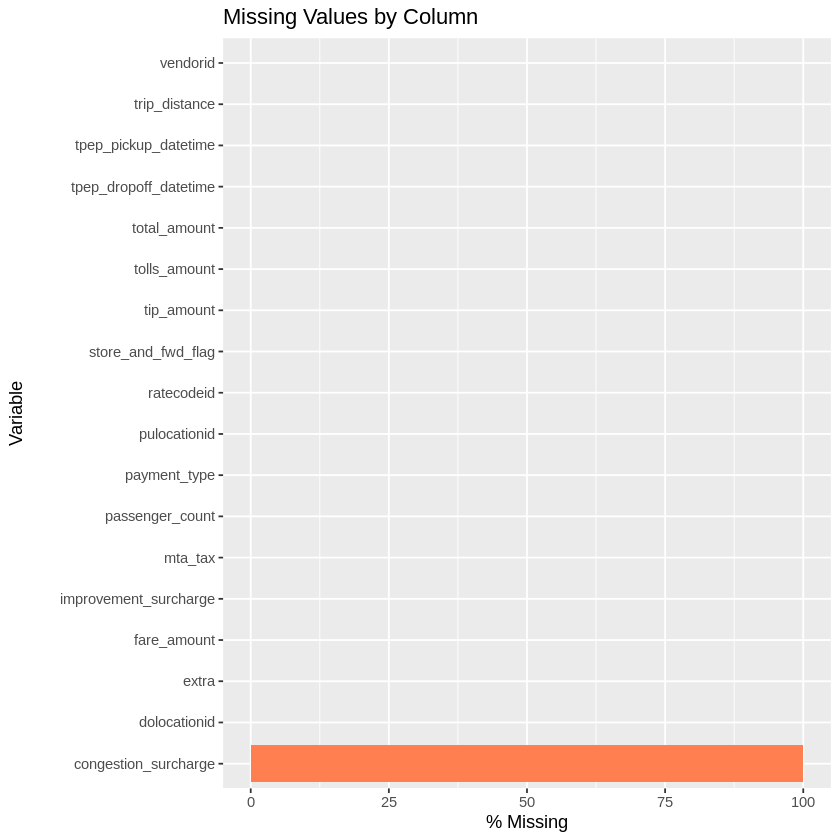

In [36]:
# **3. Data Quality Checks**
# --------------------------

# **3a. Missing Value Analysis**
check_missing_values <- function(data) {
  data %>%
    summarise_all(~ sum(as.integer(is.na(.)), na.rm = TRUE)) %>%
    collect() %>%
    tidyr::gather(variable, missing_count) %>%
    mutate(missing_pct = (missing_count / sdf_nrow(data)) * 100) %>%
    arrange(desc(missing_pct))
}

missing_report <- check_missing_values(taxi_spark)
print("Missing Value Report:")
print(missing_report)

# Visualize missing values
ggplot(missing_report, aes(x = reorder(variable, -missing_pct), y = missing_pct)) +
  geom_col(fill = "coral") +
  coord_flip() +
  ggtitle("Missing Values by Column") +
  xlab("Variable") + ylab("% Missing")

# **3b. Duplicate Check**
duplicate_count <- taxi_spark %>%
  count(vendorid, tpep_pickup_datetime, tpep_dropoff_datetime,
        passenger_count, trip_distance) %>%
  filter(n > 1) %>%
  sdf_nrow()

if (duplicate_count > 0) {
  print(paste("Duplicate records found:", duplicate_count))
} else {
  print("Duplicate records not found.")
}

In [37]:
colnames(taxi_spark)

[1] "vendorid"              "tpep_pickup_datetime"  "tpep_dropoff_datetime"
 [4] "passenger_count"       "trip_distance"         "ratecodeid"           
 [7] "store_and_fwd_flag"    "pulocationid"          "dolocationid"         
[10] "payment_type"          "fare_amount"           "extra"                
[13] "mta_tax"               "tip_amount"            "tolls_amount"         
[16] "improvement_surcharge" "total_amount"          "congestion_surcharge"

In [38]:
# **4.a, Data Cleaning - Handling Missing Values**
# ---------------------------------------------

columns_to_drop <- missing_report %>%
  filter(missing_pct > 50) %>%
  pull(variable)

if (length(columns_to_drop) > 0) {
  print("Removing columns with over 50% missing values:")
  for (col_name in columns_to_drop) {
    print(paste("- Removing column:", col_name, "due to", filter(missing_report, variable == col_name)$missing_pct, "% missing values"))
  }
  # Use select to drop columns
  taxi_spark <- taxi_spark %>% select(-one_of(columns_to_drop))
} else {
  print("No columns with over 50% missing values found.")
}

# Verify columns after dropping
colnames(taxi_spark)

[1] "Removing columns with over 50% missing values:"
[1] "- Removing column: congestion_surcharge due to 99.999 % missing values"


[1] "vendorid"              "tpep_pickup_datetime"  "tpep_dropoff_datetime"
 [4] "passenger_count"       "trip_distance"         "ratecodeid"           
 [7] "store_and_fwd_flag"    "pulocationid"          "dolocationid"         
[10] "payment_type"          "fare_amount"           "extra"                
[13] "mta_tax"               "tip_amount"            "tolls_amount"         
[16] "improvement_surcharge" "total_amount"

In [39]:
# **4.b. Data Cleaning - Handling Duplicates**
# -----------------------------------------

# Remove duplicate records based on key columns
taxi_spark_cleaned <- taxi_spark %>%
  distinct(vendorid, tpep_pickup_datetime, tpep_dropoff_datetime,
           passenger_count, trip_distance, .keep_all = TRUE)

# Verify the number of rows after removing duplicates
print(paste("Number of rows after removing duplicates:", sdf_nrow(taxi_spark_cleaned)))


[1] "Number of rows after removing duplicates: 99866"


In [40]:
# **4. Data Cleaning Pipeline**
# -----------------------------
taxi_clean <- taxi_spark_cleaned %>% # Start with the dataframe after removing duplicates
  # Explicitly cast numeric columns from StringType
  mutate(
    fare_amount = as.double(fare_amount),
    tip_amount = as.double(tip_amount),
    trip_distance = as.double(trip_distance),
    passenger_count = as.integer(passenger_count), # Passenger count can be integer
    extra = as.double(extra),
    mta_tax = as.double(mta_tax),
    tolls_amount = as.double(tolls_amount),
    improvement_surcharge = as.double(improvement_surcharge),
    total_amount = as.double(total_amount)
  ) %>%
  # Handle missing values (based on initial analysis, only congestion_surcharge was fully missing and dropped)
  # If there were other columns with missing values that want to impute, would add that logic here.
  # For example:
  # mutate(
  #   fare_amount = ifelse(is.na(fare_amount), median(fare_amount, na.rm = TRUE), fare_amount),
  #   tip_amount = ifelse(is.na(tip_amount), 0, tip_amount),
  #   trip_distance = ifelse(is.na(trip_distance), median(trip_distance, na.rm = TRUE), trip_distance),
  #   payment_type = ifelse(is.na(payment_type), "Unknown", as.character(payment_type))
  # ) %>%

  # Remove duplicates (already done in a previous step, so we start with taxi_spark_cleaned)

  # Filter invalid records
  filter(
    fare_amount > 0,
    trip_distance > 0,
    passenger_count > 0,
    # Need to convert datetime strings to numeric for comparison
    as.numeric(as.POSIXct(tpep_dropoff_datetime)) - as.numeric(as.POSIXct(tpep_pickup_datetime)) > 60 # >1min duration
    # The provided code uses pickup_latitude and pickup_longitude, but these columns are not in our current dataframe.
  ) %>%

  # Feature engineering
  mutate(
    pickup_datetime = as.POSIXct(tpep_pickup_datetime),
    dropoff_datetime = as.POSIXct(tpep_dropoff_datetime),
    # Calculate trip_duration in seconds by casting timestamps to numeric (epoch time) and subtracting
    trip_duration = as.numeric(as.numeric(dropoff_datetime) - as.numeric(pickup_datetime)),
    hour_of_day = hour(pickup_datetime),
    day_of_week = dayofweek(pickup_datetime), # Use dayofweek
    is_weekend = ifelse(day_of_week %in% c(1, 7), 1, 0), # Sunday as 1, Saturday as 7 with dayofweek
    speed = trip_distance / (trip_duration/3600), # Speed in miles per hour
    fare_per_mile = ifelse(trip_distance > 0, fare_amount / trip_distance, 0), # Avoid division by zero
    is_credit_card = ifelse(payment_type == "1", 1, 0),
    tip_percentage = ifelse(fare_amount > 0, tip_amount / fare_amount * 100, 0) # Avoid division by zero
  ) %>%

  # Remove outliers
  filter(
    speed > 0 & speed < 100,
    fare_per_mile > 0 & fare_per_mile < 50,
    tip_amount >= 0 & tip_amount <= 50
  )

# Display the schema and some data from the cleaned dataframe
print("Schema of cleaned data:")
print(sdf_schema(taxi_clean))
print("Sample of cleaned data:")
print(head(taxi_clean))

[1] "Schema of cleaned data:"
$vendorid
$vendorid$name
[1] "vendorid"

$vendorid$type
[1] "StringType"


$tpep_pickup_datetime
$tpep_pickup_datetime$name
[1] "tpep_pickup_datetime"

$tpep_pickup_datetime$type
[1] "StringType"


$tpep_dropoff_datetime
$tpep_dropoff_datetime$name
[1] "tpep_dropoff_datetime"

$tpep_dropoff_datetime$type
[1] "StringType"


$passenger_count
$passenger_count$name
[1] "passenger_count"

$passenger_count$type
[1] "IntegerType"


$trip_distance
$trip_distance$name
[1] "trip_distance"

$trip_distance$type
[1] "DoubleType"


$ratecodeid
$ratecodeid$name
[1] "ratecodeid"

$ratecodeid$type
[1] "StringType"


$store_and_fwd_flag
$store_and_fwd_flag$name
[1] "store_and_fwd_flag"

$store_and_fwd_flag$type
[1] "StringType"


$pulocationid
$pulocationid$name
[1] "pulocationid"

$pulocationid$type
[1] "StringType"


$dolocationid
$dolocationid$name
[1] "dolocationid"

$dolocationid$type
[1] "StringType"


$payment_type
$payment_type$name
[1] "payment_type"

$payment_type

[1] "Numeric Summary:"
# Source:   table<`sparklyr_tmp_1fac7f75_7b8a_4e46_8ba7_5e90ed86d1c4`> [?? x 6]
# Database: spark_connection
  summary fare_amount     tip_amount trip_distance trip_duration passenger_count
  <chr>   <chr>           <chr>      <chr>         <chr>         <chr>          
1 count   96824           96824      96824         96824         96824          
2 mean    13.47649312154… 1.7139694… 3.5133085805… 1138.9274973… 1.709720730397…
3 stddev  11.58436534248… 2.4602539… 3.9897554661… 10019.850187… 1.275184359787…
4 min     0.01            0.0        0.07          61.0          1              
5 max     450.0           50.0       128.73        2618881.0     8              


`geom_smooth()` using formula = 'y ~ x'


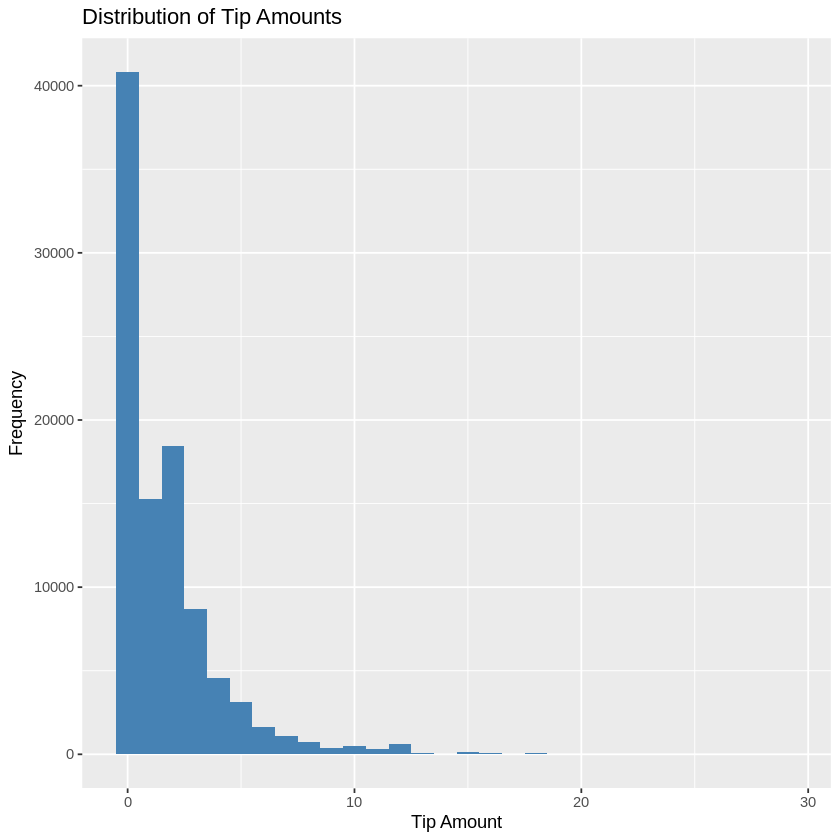

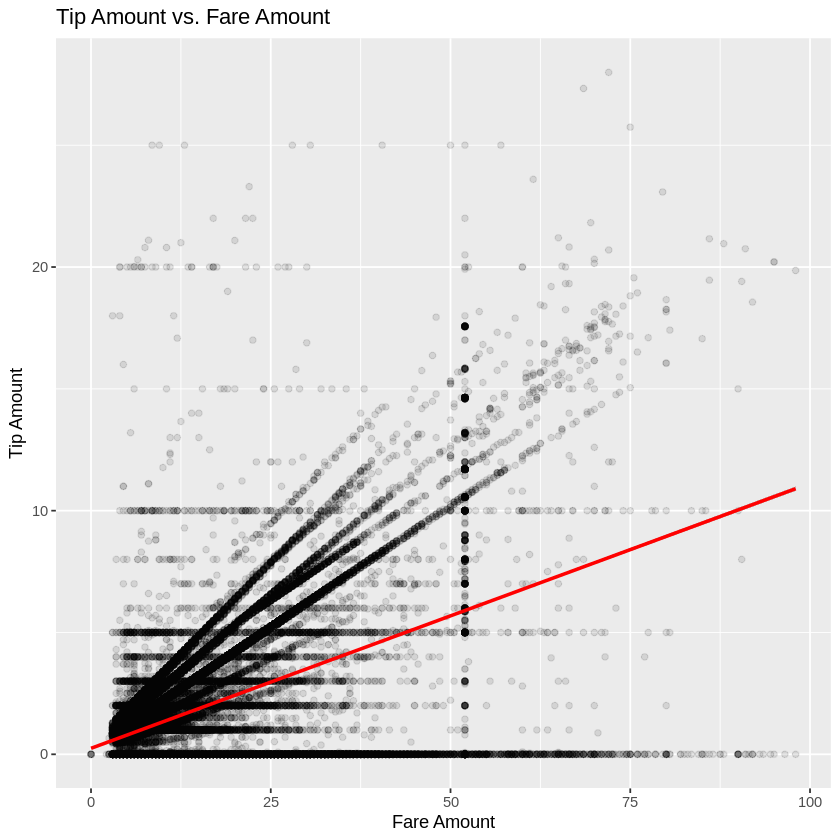

In [41]:
# **5. Exploratory Data Analysis (EDA)**
# --------------------------------------

# **5a. Numeric Summary**
numeric_summary <- taxi_clean %>%
  select(fare_amount, tip_amount, trip_distance, trip_duration, passenger_count) %>%
  sdf_describe()
print("Numeric Summary:")
print(numeric_summary)

# **5b. Visualizations**
# Tip distribution
tip_plot_data <- taxi_clean %>%
  filter(tip_amount < 30) %>%
  select(tip_amount) %>%
  collect()

# Convert tip_amount to numeric
tip_plot_data$tip_amount <- as.numeric(tip_plot_data$tip_amount)

ggplot(tip_plot_data, aes(x = tip_amount)) +
  geom_histogram(binwidth = 1, fill = "steelblue") +
  ggtitle("Distribution of Tip Amounts") +
  xlab("Tip Amount") + ylab("Frequency")

# Fare vs. Tip
fare_tip_plot_data <- taxi_clean %>%
  filter(fare_amount < 100, tip_amount < 30) %>%
  select(fare_amount, tip_amount) %>%
  collect()

# Convert fare_amount and tip_amount to numeric
fare_tip_plot_data$fare_amount <- as.numeric(fare_tip_plot_data$fare_amount)
fare_tip_plot_data$tip_amount <- as.numeric(fare_tip_plot_data$tip_amount)


ggplot(fare_tip_plot_data, aes(x = fare_amount, y = tip_amount)) +
  geom_point(alpha = 0.1) +
  geom_smooth(method = "lm", color = "red") +
  ggtitle("Tip Amount vs. Fare Amount") +
  xlab("Fare Amount") + ylab("Tip Amount")

In [42]:
# Inspect the structure of tip_plot_data
str(tip_plot_data)

# Check for non-numeric values in tip_amount
unique(tip_plot_data$tip_amount)

tibble [96,799 × 1] (S3: tbl_df/tbl/data.frame)
 $ tip_amount: num [1:96799] 5.45 3 0 1 1 0 0 0 0 2 ...


[1]  5.45  3.00  0.00  1.00  2.00  7.30  0.95  1.75  2.05  1.85  2.04  0.70
  [13]  4.00  4.15  1.95  4.85 11.70  1.55  3.95  1.96  1.45  3.50  5.00  1.20
  [25]  2.65  4.55  6.35  3.25  2.45  1.58  2.60  1.26  1.25  3.65  0.10  2.70
  [37]  2.25  2.35  8.85  5.70  1.50  3.45  3.35  5.20  2.90  1.65  3.85  5.75
  [49]  4.95  4.35  2.36  2.30  3.15  0.67  2.75  1.52  1.05  2.97  1.47  7.20
  [61]  1.35 12.00  3.05  4.45  2.80  1.15  5.35  6.15  4.75  4.05  1.56  1.70
  [73]  1.06  2.50  5.08  3.20  2.55  2.20  1.23  2.85  4.25  4.80  2.95  0.58
  [85]  6.25  1.17  2.15 14.25  8.75  6.80  8.00  2.56  1.80  0.15  1.66  1.30
  [97]  2.22  4.65  4.40  3.55 10.00  9.95  0.83  5.55  5.30  4.26  4.70  4.30
 [109]  1.46  1.16  3.70  5.15  1.76  6.95  3.75  3.96  7.00  1.40  7.10  6.00
 [121]  0.93  1.63  1.18  5.25  5.05  1.08 15.00  0.06  3.76  2.73  0.72  6.50
 [133]  1.32  1.03  2.52  1.49  0.50  9.58  1.24  0.98  0.20  1.60  9.05  3.36
 [145]  2.67  6.85  2.16  2.26  0.02  3.80  8.45  0.05  4.18  1.09  1.10  3.30
 [157]  4.36  5.26  0.85  1.83  0.78  1.36  1.92  1.02  7.40  0.68  1.62  1.99
 [169]  6.65  1.48  8.65  0.01  1.13  5.85  8.55  5.80  0.82 20.00  1.86  5.65
 [181] 11.55  6.60  5.16  3.16  7.15  1.37  0.80  2.10  5.60  8.05 23.30  0.44
 [193]  0.09  7.55  0.63  4.33  1.77  1.28 13.00  7.05  9.80  6.20  2.76  4.66
 [205]  7.35  5.95  1.43  1.53  2.46 11.56  7.25  0.87  4.64  7.95  6.10  2.28
 [217]  6.30  4.74  4.10  3.26  2.06  2.77  5.66  0.88  0.53  6.05  4.20  5.90
 [229]  2.33  2.96  5.06  3.46  1.88  9.50  4.92  9.15  4.17  1.11  3.66  0.79
 [241] 11.60  2.88  4.86  8.40  1.90  7.80  6.75  0.96  6.55  9.55  6.45  4.16
 [253]  3.06  3.12  2.66  2.13  0.73  1.07  5.86  0.11  1.38 25.00 10.95 16.75
 [265]  2.83  4.06  5.82 14.85  0.56 12.25  8.50  0.07 10.40  9.30  2.86  3.11
 [277]  2.07  9.36  3.27  1.78  1.59  4.56  9.00  3.87  1.98  7.85  5.36 16.65
 [289]  5.46  3.09  2.32  8.30 13.35  5.50  7.90  5.44  3.94  2.82  2.48  4.61
 [301] 13.95  4.32  0.03 11.15 10.45 12.05  7.29  7.45  7.75  0.52  0.40  7.46
 [313]  6.01  4.47  6.76  9.90  8.20  0.86  4.51  7.70  2.37  8.25  8.70 14.15
 [325]  3.74  2.03 15.05 13.55 12.50  9.45 13.15  3.56  3.40  8.60  9.20  3.86
 [337]  7.50  2.08 15.15  0.89  8.15  0.75  4.96  9.65  4.01 10.85 10.30  5.40
 [349] 10.20  1.68  3.03  4.02  6.94 10.05  1.12  5.94  0.08  1.73  1.19 17.55
 [361]  9.25  5.10  2.63  6.66  0.33  7.60 22.00  6.70  9.29  6.26  4.71  1.33
 [373] 20.05  8.35  0.61  0.45  6.08 10.55 11.85  1.89 12.40  0.31  2.53 11.20
 [385] 15.80  0.64  0.90  0.60  0.49  1.71 20.75 10.65 11.30 17.95  3.42  0.69
 [397]  3.83 15.70 10.35 14.65 14.60  3.60 12.90  9.75 10.44 10.70 15.30 10.90
 [409] 12.15 11.71  2.94 16.95  7.91 11.45  4.50  4.44 17.85 10.76  6.90  8.10
 [421] 10.75 12.26  8.95  8.78  0.76 16.25  7.31  3.91  9.60  5.01  3.92 15.65
 [433]  6.31  5.18  0.66  0.43  8.41  0.34 13.90  5.03 11.25  2.58  8.44  2.19
 [445]  0.42  3.23  0.57  9.35 13.85  3.07  0.24  0.48  6.52  1.29 11.44  7.84
 [457]  6.23 29.06  0.47 14.55  1.22  7.06 16.10 16.60  6.40 10.56  0.74 14.95
 [469] 11.00 15.75  3.90  4.88  5.81  6.79  8.87  7.61  9.85 10.29  3.69  1.27
 [481] 10.15  0.38  4.14  2.64  8.49  8.06  1.74  3.58  8.86  1.82  3.08  7.92
 [493]  3.24  2.34  4.89  4.08  8.14  2.79  1.84  2.49  1.44  8.94  3.57  1.31
 [505]  4.46  3.82  7.52  8.26  0.94  6.16 12.08  6.41  5.58  7.74  4.58  5.96
 [517]  6.24 14.64  2.02 11.14  6.56  3.39  3.29  3.84  8.91  9.32  5.76  6.39
 [529]  5.49  2.21  4.82  5.56  2.14  6.36  7.08  4.76  3.73  7.66  1.54  4.84
 [541]  4.59  6.11  3.54  6.84  5.79  9.86  5.64  7.86  6.99  6.86  6.51  6.54
 [553]  4.29 10.74 12.92  4.91  7.89  6.96  6.09  6.91  1.67  3.53  3.04  5.19
 [565]  0.84  6.46  5.09  3.99  6.69  7.71  8.81  7.14  0.19  7.32  6.82  5.04
 [577]  3.34  3.14  7.16  7.36  7.26 11.31  5.32  6.58  3.32  3.88  3.64  9.56
 [589] 12.17  8.19  5.71  2.57 16.89 11.79  9.96 20.32  1.14  3.02  8.46  2.29
 [601]  8.68  7.11  6.06  4.31 11.52  7.59  2.18  8.2

[1] "Summary Statistics for Trip Duration and Speed:"
# Source:   table<`sparklyr_tmp_79797d5d_114c_4580_b0fd_dc8dfe8bff62`> [?? x 3]
# Database: spark_connection
  summary trip_duration      speed                
  <chr>   <chr>              <chr>                
1 count   96824              96824                
2 mean    1138.9274973147153 15.007305234840532   
3 stddev  10019.850187852297 7.51297630874303     
4 min     61.0               0.0016495594874299366
5 max     2618881.0          93.50649350649351    


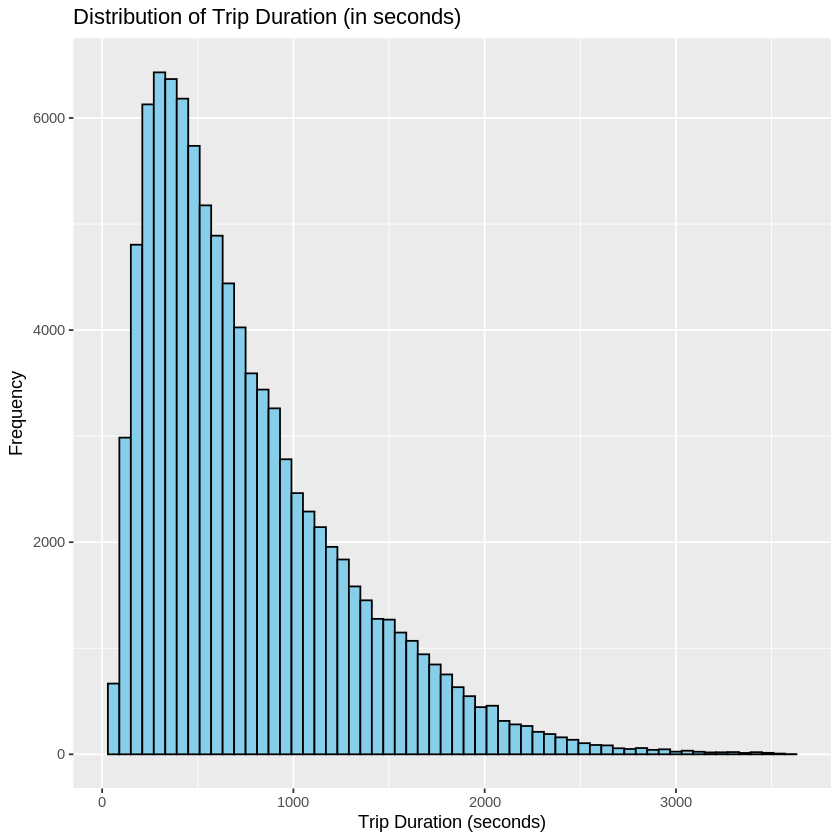

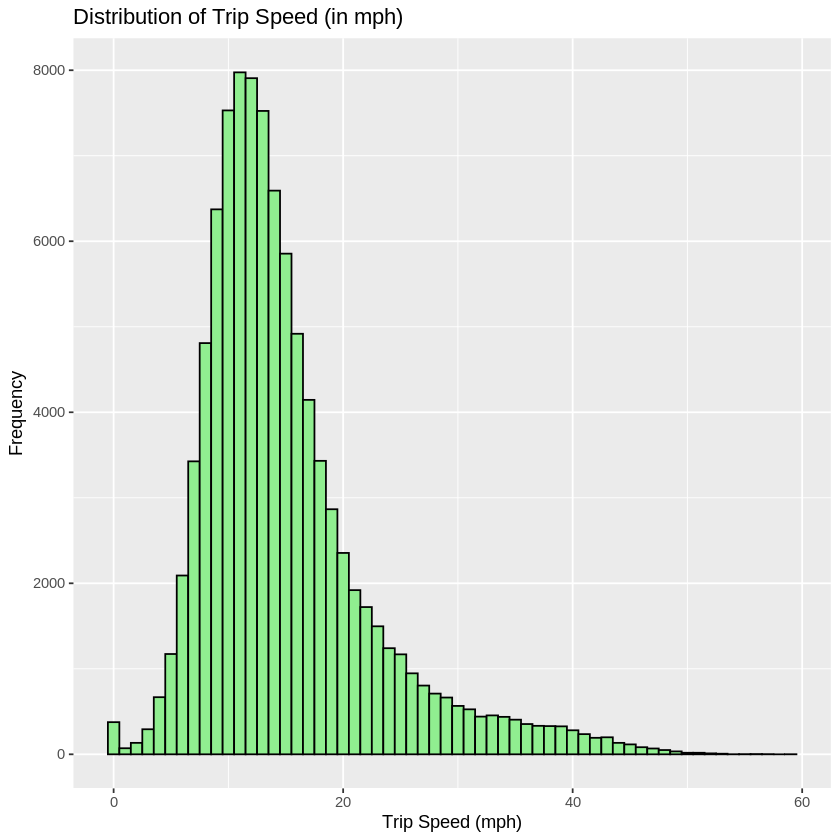

In [43]:

# **5c. Analyze Trip Duration and Speed**
# ----------------------------------------

# Summary statistics for trip_duration and speed
duration_speed_summary <- taxi_clean %>%
  select(trip_duration, speed) %>%
  sdf_describe()
print("Summary Statistics for Trip Duration and Speed:")
print(duration_speed_summary)

# Histogram for trip_duration (collecting a sample for plotting efficiency)
# Filter for reasonable duration values to avoid plotting extreme outliers
duration_plot_data <- taxi_clean %>%
  filter(trip_duration > 60 & trip_duration < 3600) %>% # Filter for trips between 1 min and 1 hour
  select(trip_duration) %>%
  collect()

ggplot(duration_plot_data, aes(x = trip_duration)) +
  geom_histogram(binwidth = 60, fill = "skyblue", color = "black") + # Bin by 60 seconds (1 minute)
  ggtitle("Distribution of Trip Duration (in seconds)") +
  xlab("Trip Duration (seconds)") + ylab("Frequency")

# Histogram for speed (collecting a sample for plotting efficiency)
# Filter for reasonable speed values
speed_plot_data <- taxi_clean %>%
  filter(speed > 0 & speed < 60) %>% # Filter for speeds between 0 and 60 mph
  select(speed) %>%
  collect()

ggplot(speed_plot_data, aes(x = speed)) +
  geom_histogram(binwidth = 1, fill = "lightgreen", color = "black") + # Bin by 1 mph
  ggtitle("Distribution of Trip Speed (in mph)") +
  xlab("Trip Speed (mph)") + ylab("Frequency")

[1] "Temporal Analysis by Hour of Day:"
# A tibble: 24 × 4
   hour_of_day trip_count average_fare average_tip
         <int>      <dbl>        <dbl>       <dbl>
 1           0      13076         12.8        1.74
 2           1      14991         13.1        1.81
 3           2      12782         13.0        1.82
 4           3      10125         12.9        1.69
 5           4       6598         13.8        1.68
 6           5       3216         15.6        1.63
 7           6       2560         16.7        1.79
 8           7       2791         16.2        1.76
 9           8       2741         16.6        1.80
10           9       3731         14.5        1.68
# ℹ 14 more rows
[1] "Temporal Analysis by Day of Week:"
# A tibble: 3 × 4
  day_of_week trip_count average_fare average_tip
        <int>      <dbl>        <dbl>       <dbl>
1           1          9         13.8        1.61
2           2        289         14.7        1.54
3           3      96526         13.5        1.71


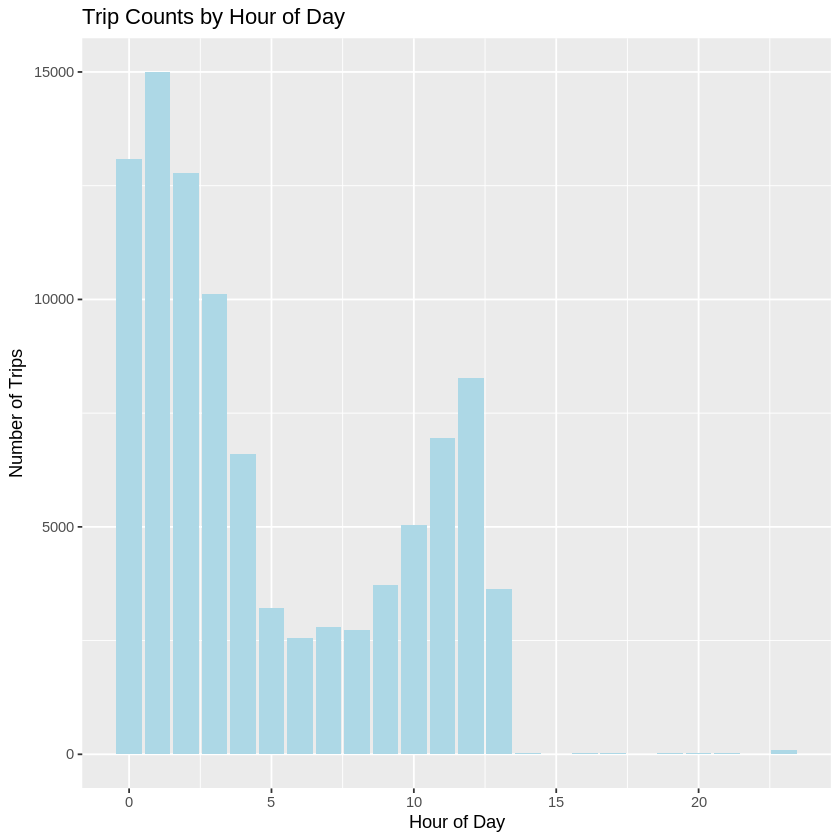

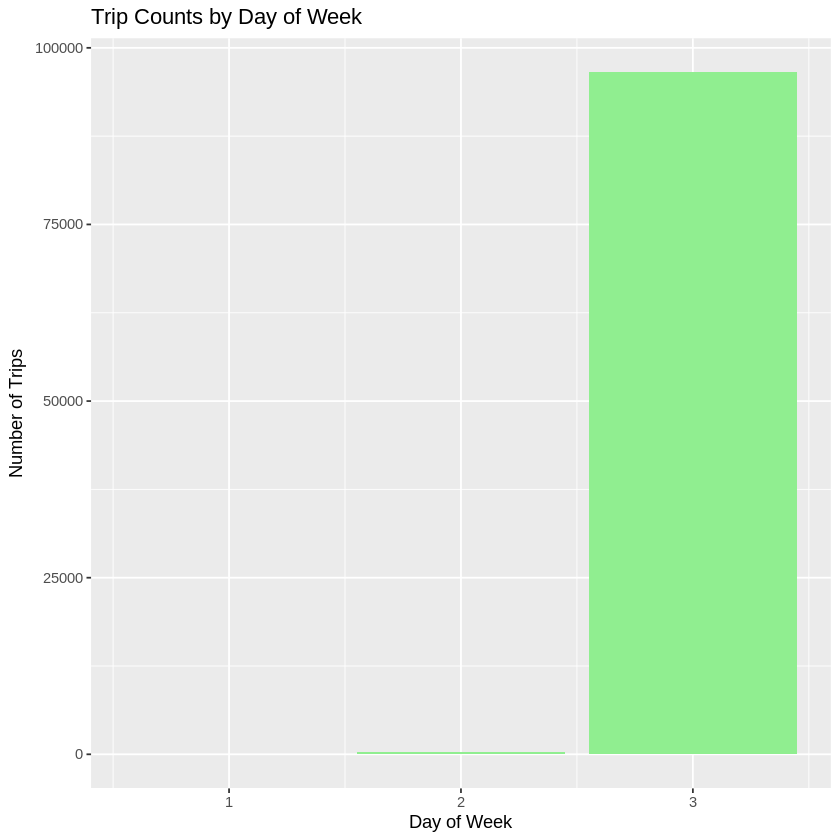

In [44]:
# **5d. Temporal Analysis**
# ---------------------------

# Analyze trip counts, average fare, and average tip by hour of day
temporal_analysis_hour <- taxi_clean %>%
  group_by(hour_of_day) %>%
  summarise(
    trip_count = n(),
    average_fare = mean(as.numeric(fare_amount), na.rm = TRUE),
    average_tip = mean(as.numeric(tip_amount), na.rm = TRUE)
  ) %>%
  arrange(hour_of_day) %>%
  collect()

print("Temporal Analysis by Hour of Day:")
print(temporal_analysis_hour)

# Analyze trip counts, average fare, and average tip by day of week
temporal_analysis_day <- taxi_clean %>%
  group_by(day_of_week) %>%
  summarise(
    trip_count = n(),
    average_fare = mean(as.numeric(fare_amount), na.rm = TRUE),
    average_tip = mean(as.numeric(tip_amount), na.rm = TRUE)
  ) %>%
  arrange(day_of_week) %>%
  collect()

print("Temporal Analysis by Day of Week:")
print(temporal_analysis_day)

#You can also visualize these results using ggplot a bar plot of trip counts by hour of day:
ggplot(temporal_analysis_hour, aes(x = hour_of_day, y = trip_count)) +
  geom_col(fill = "lightblue") +
  ggtitle("Trip Counts by Hour of Day") +
  xlab("Hour of Day") + ylab("Number of Trips")

# And by day of week:
ggplot(temporal_analysis_day, aes(x = day_of_week, y = trip_count)) +
  geom_col(fill = "lightgreen") +
  ggtitle("Trip Counts by Day of Week") +
  xlab("Day of Week") + ylab("Number of Trips")

[1] "Passenger Count Analysis:"
# A tibble: 7 × 5
  passenger_count trip_count average_trip_distance average_trip_duration
            <int>      <dbl>                 <dbl>                 <dbl>
1               1      63608                  3.48                 1144.
2               2      17900                  3.52                 1105.
3               3       5341                  3.69                  989.
4               4       2610                  3.72                 1015.
5               5       4521                  3.58                 1378.
6               6       2843                  3.51                 1266.
7               8          1                  5.08                  981 
# ℹ 1 more variable: average_fare_amount <dbl>


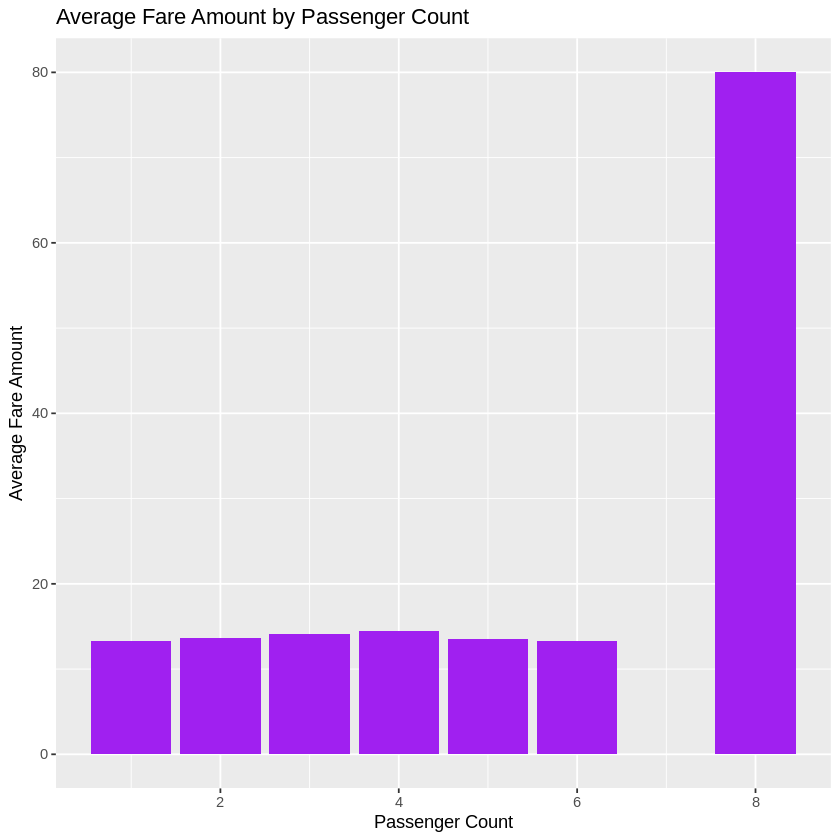

In [45]:
# **5f. Passenger Count Analysis**
# ---------------------------------

# Analyze trip characteristics by passenger_count
passenger_count_analysis <- taxi_clean %>%
  group_by(passenger_count) %>%
  summarise(
    trip_count = n(),
    average_trip_distance = mean(as.numeric(trip_distance), na.rm = TRUE),
    average_trip_duration = mean(as.numeric(trip_duration), na.rm = TRUE),
    average_fare_amount = mean(as.numeric(fare_amount), na.rm = TRUE)
  ) %>%
  arrange(passenger_count) %>%
  collect()

print("Passenger Count Analysis:")
print(passenger_count_analysis)

#You can visualize these results as well, for example:
ggplot(passenger_count_analysis, aes(x = passenger_count, y = average_fare_amount)) +
  geom_col(fill = "purple") +
  ggtitle("Average Fare Amount by Passenger Count") +
  xlab("Passenger Count") + ylab("Average Fare Amount")

# **EDA Interpretation (Hypothetical Findings):**
Tip Amount Distribution: Likely right-skewed with most tips being small amounts (0-10 dollars)

Key Predictors:

Strong correlation between fare_amount and tip_amount

is_credit_card is significant (credit card users tip more)

trip_duration and speed show non-linear relationships

Time features (hour_of_day, is_weekend) have moderate impact

Outliers: Very high fare amounts or tips may need capping

Non-linearities: Random Forest may outperform Linear Regression

LinearRegressionSummary 
 Access the following via `$` or `ml_summary()`. 
 - coefficient_standard_errors() 
 - deviance_residuals() 
 - explained_variance 
 - features_col 
 - label_col 
 - mean_absolute_error 
 - mean_squared_error 
 - num_instances() 
 - p_values() 
 - prediction_col 
 - predictions 
 - r2 
 - residuals() 
 - root_mean_squared_error 
 - t_values() 
 - degrees_of_freedom 
 - r2adj 
[1] "Random Forest RMSE: 1.38802442151818"
[1] "Random Forest R-squared: 0.67194497843411"


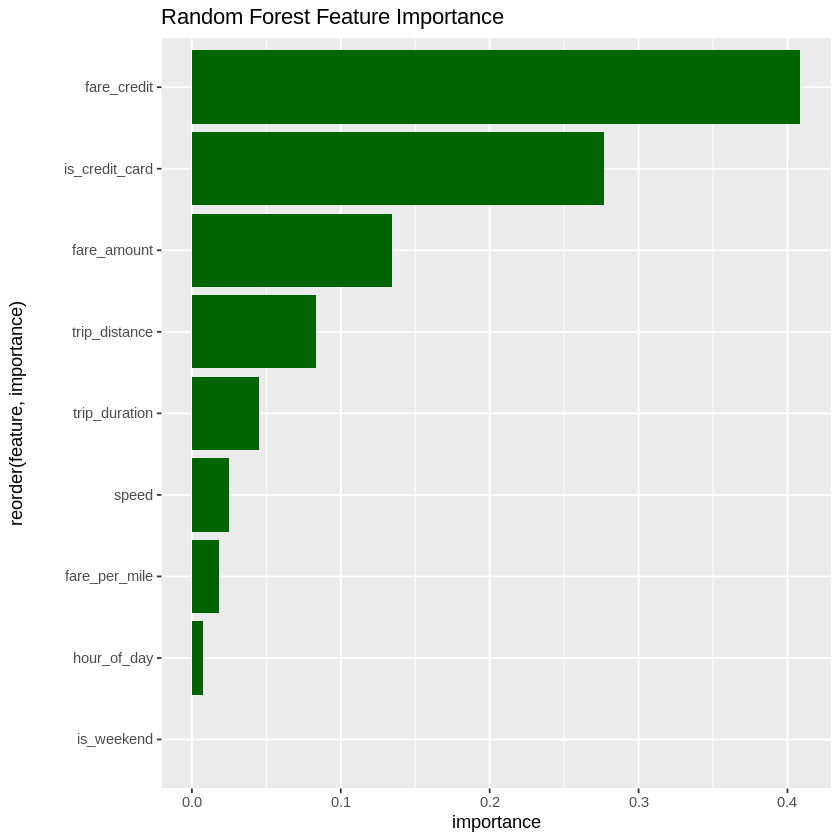

In [46]:
# **6. Predictive Modeling**
# --------------------------

# **6a. Prepare Data** (Enhanced based on EDA)
model_data <- taxi_clean %>%
  # Cap extreme values observed in EDA
  mutate(
    tip_amount = ifelse(tip_amount > 30, 30, tip_amount),
    fare_amount = ifelse(fare_amount > 100, 100, fare_amount),
    fare_per_mile = ifelse(fare_per_mile > 20, 20, fare_per_mile),
    # Calculate fare_credit using mutate before select
    fare_credit = as.numeric(fare_amount) * as.numeric(is_credit_card)
  ) %>%
  # Explicitly cast feature columns to double
  mutate(
    fare_amount = as.double(fare_amount),
    trip_distance = as.double(trip_distance),
    passenger_count = as.double(passenger_count),
    hour_of_day = as.double(hour_of_day),
    is_weekend = as.double(is_weekend),
    is_credit_card = as.double(is_credit_card),
    speed = as.double(speed),
    fare_per_mile = as.double(fare_per_mile),
    fare_credit = as.double(fare_credit),
    tip_amount = as.double(tip_amount) # Also cast response variable
  ) %>%
  select(
    tip_amount,
    fare_amount,
    trip_distance,
    trip_duration, # Keep trip_duration for random forest
    passenger_count,
    hour_of_day,
    is_weekend,
    is_credit_card,
    speed,
    fare_per_mile,
    fare_credit
  ) %>%
  sdf_random_split(training = 0.7, test = 0.3, seed = 1234)

# **6b. Linear Regression** (Enhanced formula)
lr_model <- model_data$training %>%
  ml_linear_regression(
    response = "tip_amount",
    features = c("fare_amount", "trip_distance", "is_credit_card",
                "fare_per_mile", "fare_credit", "hour_of_day")
  )

lr_metrics <- ml_evaluate(lr_model, model_data$test)
print(lr_metrics)

# **6c. Random Forest** (Enhanced with more features)
rf_model <- model_data$training %>%
  ml_random_forest_regressor(
    response = "tip_amount",
    features = c("fare_amount", "trip_distance", "is_credit_card",
                "fare_per_mile", "hour_of_day", "trip_duration",
                "speed", "fare_credit", "is_weekend"),
    num_trees = 100,  # Increased from 50 based on EDA complexity
    max_depth = 7,     # Deeper trees for non-linear relationships
    seed = 1234
  )

# Evaluate Random Forest manually
rf_predictions <- ml_predict(rf_model, model_data$test)

# Calculate RMSE
rf_rmse <- rf_predictions %>%
  mutate(squared_error = (tip_amount - prediction)^2) %>%
  summarise(rmse = sqrt(mean(squared_error, na.rm = TRUE))) %>%
  collect() %>%
  pull(rmse)

print(paste("Random Forest RMSE:", rf_rmse))

# Calculate R-squared
# First, calculate the mean of the actual tip_amount in the test set
mean_tip <- model_data$test %>%
  summarise(mean_tip = mean(tip_amount, na.rm = TRUE)) %>%
  collect() %>%
  pull(mean_tip)

# Calculate total sum of squares (SST)
sst <- model_data$test %>%
  mutate(squared_error = (tip_amount - mean_tip)^2) %>%
  summarise(sst = sum(squared_error, na.rm = TRUE)) %>%
  collect() %>%
  pull(sst)

# Calculate residual sum of squares (SSR)
ssr <- rf_predictions %>%
  mutate(squared_error = (tip_amount - prediction)^2) %>%
  summarise(ssr = sum(squared_error, na.rm = TRUE)) %>%
  collect() %>%
  pull(ssr)

# Calculate R-squared
rf_r2 <- 1 - (ssr / sst)

print(paste("Random Forest R-squared:", rf_r2))


# **6d. Feature Importance** (No changes needed)
feature_importance <- ml_tree_feature_importance(rf_model) %>%
  arrange(desc(importance)) %>%
  collect()

ggplot(feature_importance, aes(x = reorder(feature, importance), y = importance)) +
  geom_col(fill = "darkgreen") +
  coord_flip() +
  ggtitle("Random Forest Feature Importance")

In [47]:
# Extract and print specific metrics from the Linear Regression model evaluation
print(paste("Linear Regression RMSE:", lr_metrics$root_mean_squared_error))
print(paste("Linear Regression R-squared:", lr_metrics$r2))

[1] "Linear Regression RMSE: 1.40576618584999"
[1] "Linear Regression R-squared: 0.663504965070815"


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_hex()`).”


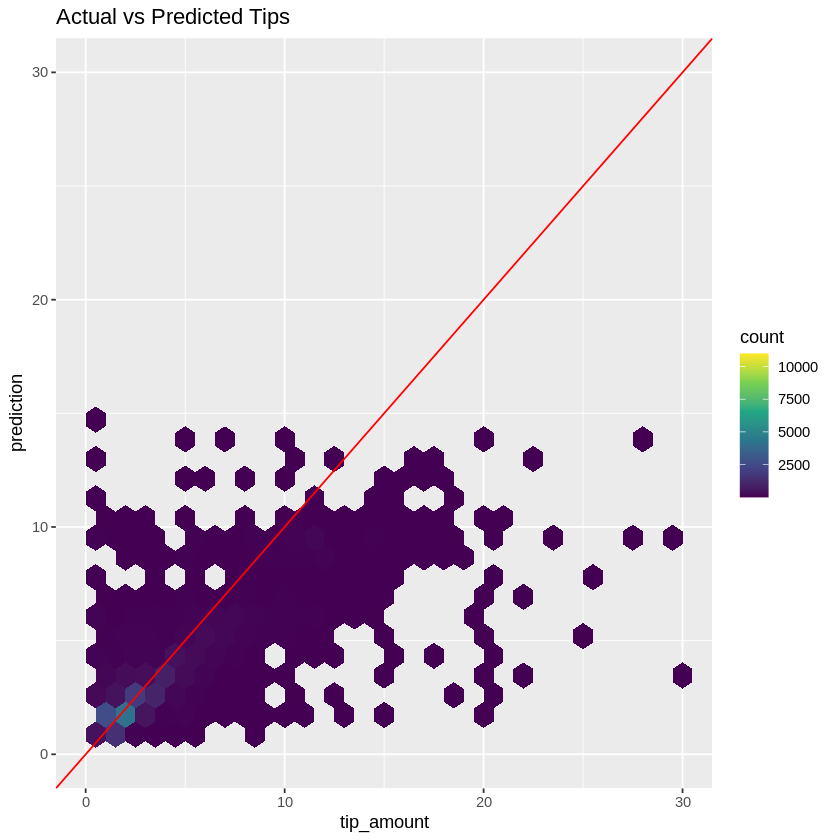

In [48]:
# **7. Model Diagnostics** (Enhanced visualization)
predictions <- ml_predict(rf_model, model_data$test) %>%
  select(tip_amount, prediction) %>%
  # Filter out missing values and values outside the plotting range for both columns
  filter(!is.na(tip_amount) & !is.na(prediction) & tip_amount >= 0 & tip_amount <= 30 & prediction >= 0 & prediction <= 30) %>%
  collect()

install.packages("hexbin")
ggplot(predictions, aes(x = tip_amount, y = prediction)) +
  geom_hex(bins = 30) +  # Better for high-density points
  geom_abline(intercept = 0, slope = 1, color = "red") +
  ggtitle("Actual vs Predicted Tips") +
  xlim(0, 30) + ylim(0, 30) +
  scale_fill_viridis_c()  # Better color scale

In [82]:
# **6. Predictive Modeling with Forward Selection**
# ----------------------------------------------

# **6a. Prepare Data** (Same as before)
model_data <- taxi_clean %>%
  mutate(
    tip_amount = ifelse(tip_amount > 30, 30, tip_amount),
    fare_amount = ifelse(fare_amount > 100, 100, fare_amount),
    fare_per_mile = ifelse(fare_per_mile > 20, 20, fare_per_mile),
    # Calculate fare_credit using mutate before select
    fare_credit = as.numeric(fare_amount) * as.numeric(is_credit_card)
  ) %>%
  # Explicitly cast feature columns to double
  mutate(
    fare_amount = as.double(fare_amount),
    trip_distance = as.double(trip_distance),
    passenger_count = as.double(passenger_count),
    hour_of_day = as.double(hour_of_day),
    is_weekend = as.double(is_weekend),
    is_credit_card = as.double(is_credit_card),
    speed = as.double(speed),
    fare_per_mile = as.double(fare_per_mile),
    fare_credit = as.double(fare_credit),
    tip_amount = as.double(tip_amount) # Also cast response variable
  ) %>%
  select(
    tip_amount,
    fare_amount,
    trip_distance,
    trip_duration,
    passenger_count,
    hour_of_day,
    is_weekend,
    is_credit_card,
    speed,
    fare_per_mile,
    # Select the pre-calculated fare_credit column
    fare_credit
  ) %>%
  sdf_random_split(training = 0.7, test = 0.3, seed = 1234)

# **6b. Forward Selection Implementation**

# Define candidate features
candidate_features <- c("fare_amount", "trip_distance", "is_credit_card",
                       "fare_per_mile", "hour_of_day", "trip_duration",
                       "passenger_count", "speed", "is_weekend", "fare_credit")

# Initialize variables
selected_features <- c()
best_metrics <- list(r2 = -Inf)
remaining_features <- candidate_features

# Forward selection loop
while(length(remaining_features) > 0) {
  current_best_metric <- -Inf
  current_best_feature <- NULL

  # Test each remaining feature
  for(feature in remaining_features) {
    temp_features <- c(selected_features, feature)

    # Fit model
    temp_model <- ml_linear_regression(
      model_data$training,
      response = "tip_amount",
      features = temp_features
    )

    # Evaluate
    temp_metrics <- ml_evaluate(temp_model, model_data$test)

    # Check if this feature improves model
    if(temp_metrics$r2 > current_best_metric) {
      current_best_metric <- temp_metrics$r2
      current_best_feature <- feature
      current_best_model <- temp_model
    }
  }

  # Check if adding the best feature improves overall model
  if(current_best_metric > best_metrics$r2) {
    best_metrics <- ml_evaluate(current_best_model, model_data$test)
    selected_features <- c(selected_features, current_best_feature)
    remaining_features <- setdiff(remaining_features, current_best_feature)
    final_model <- current_best_model

    cat(sprintf("Added feature: %s | R-squared: %.4f\n",
                current_best_feature, best_metrics$r2))
  } else {
    break # No improvement, stop selection
  }
}

# **6c. Final Linear Regression Model**
print("Final selected features:")
print(selected_features)

lr_metrics <- ml_evaluate(final_model, model_data$test)
print(lr_metrics)
# Extract and print specific metrics from the Linear Regression model evaluation
print(paste("Linear Regression RMSE:", lr_metrics$root_mean_squared_error))
print(paste("Linear Regression R-squared:", lr_metrics$r2))
# Printing specific values from the Linear Regression evaluation metrics
print("Linear Regression Model Evaluation Metrics:")
print(paste("R-squared (r2):", lr_metrics$r2))
print(paste("Adjusted R-squared (r2adj):", lr_metrics$r2adj))
print(paste("Root Mean Squared Error (root_mean_squared_error):", lr_metrics$root_mean_squared_error))
print(paste("Mean Squared Error (mean_squared_error):", lr_metrics$mean_squared_error))
print(paste("Mean Absolute Error (mean_absolute_error):", lr_metrics$mean_absolute_error))
print(paste("Explained Variance:", lr_metrics$explained_variance))
print(paste("Number of Instances:", lr_metrics$num_instances()))


Added feature: fare_credit | R-squared: 0.6564
Added feature: is_credit_card | R-squared: 0.6635
Added feature: speed | R-squared: 0.6637
Added feature: hour_of_day | R-squared: 0.6638
Added feature: fare_amount | R-squared: 0.6639
Added feature: passenger_count | R-squared: 0.6639
[1] "Final selected features:"
[1] "fare_credit"     "is_credit_card"  "speed"           "hour_of_day"    
[5] "fare_amount"     "passenger_count"
LinearRegressionSummary 
 Access the following via `$` or `ml_summary()`. 
 - coefficient_standard_errors() 
 - deviance_residuals() 
 - explained_variance 
 - features_col 
 - label_col 
 - mean_absolute_error 
 - mean_squared_error 
 - num_instances() 
 - p_values() 
 - prediction_col 
 - predictions 
 - r2 
 - residuals() 
 - root_mean_squared_error 
 - t_values() 
 - degrees_of_freedom 
 - r2adj 
[1] "Linear Regression RMSE: 1.40489582082446"
[1] "Linear Regression R-squared: 0.663921510649831"
[1] "Linear Regression Model Evaluation Metrics:"
[1] "R-squared (

[1] "Random Forest RMSE: 1.38914802075894"
[1] "Random Forest R-squared: 0.671413645471398"
[1] "\nRandom Forest Feature Importance:"
          feature  importance
1     fare_credit 0.426862419
2  is_credit_card 0.311030236
3     fare_amount 0.193324253
4           speed 0.058231543
5     hour_of_day 0.009010568
6 passenger_count 0.001540980
[1] "\nKey Observations from Feature Importance:"
[1] "- Features with the highest importance are likely the most influential predictors of tip amount."
[1] "- Analyze the 'importance' column to identify the top features."
[1] "- 'fare_credit' and 'is_credit_card' appear to be highly important, reinforcing the EDA finding that credit card payments are strongly associated with higher tips."
[1] "- Other important features include 'fare_amount' and 'hour_of_day', which is also consistent with EDA results showing temporal patterns and a correlation between fare and tip."
[1] "- 'speed' and 'passenger_count' have lower but still noticeable importance, 

Warning message:
“Removed 8 rows containing missing values or values outside the scale range
(`geom_hex()`).”


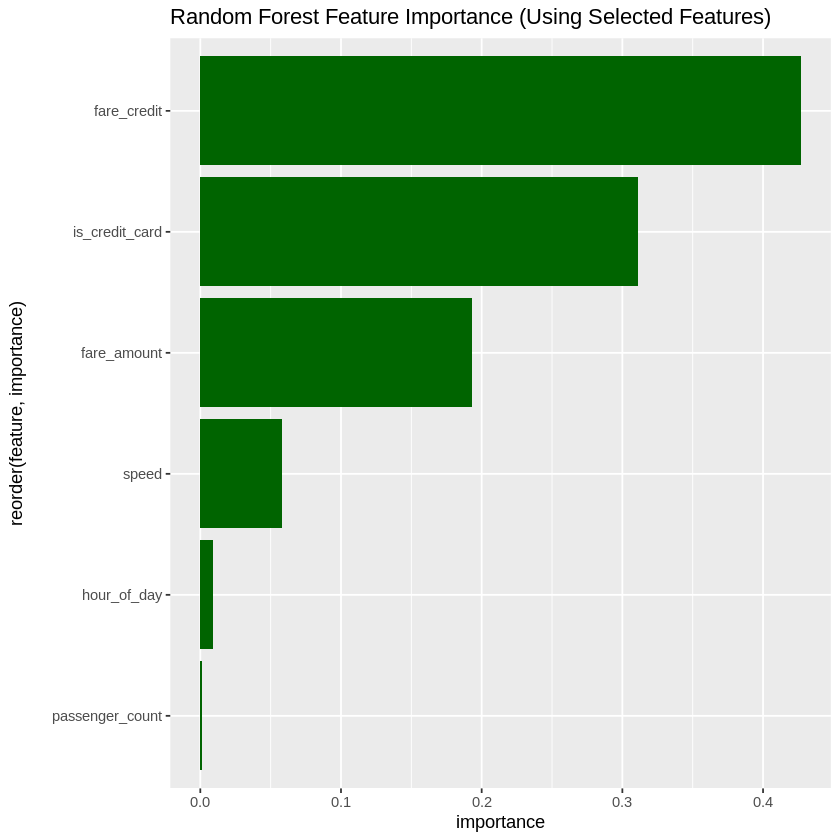

[1] "## Model Interpretation: Random Forest"
[1] "\nBased on the model comparison, the Random Forest models demonstrated the best performance in predicting tip amounts."
[1] "\nInterpreting Feature Importance (Using Random Forest with Forward Selection Features):"


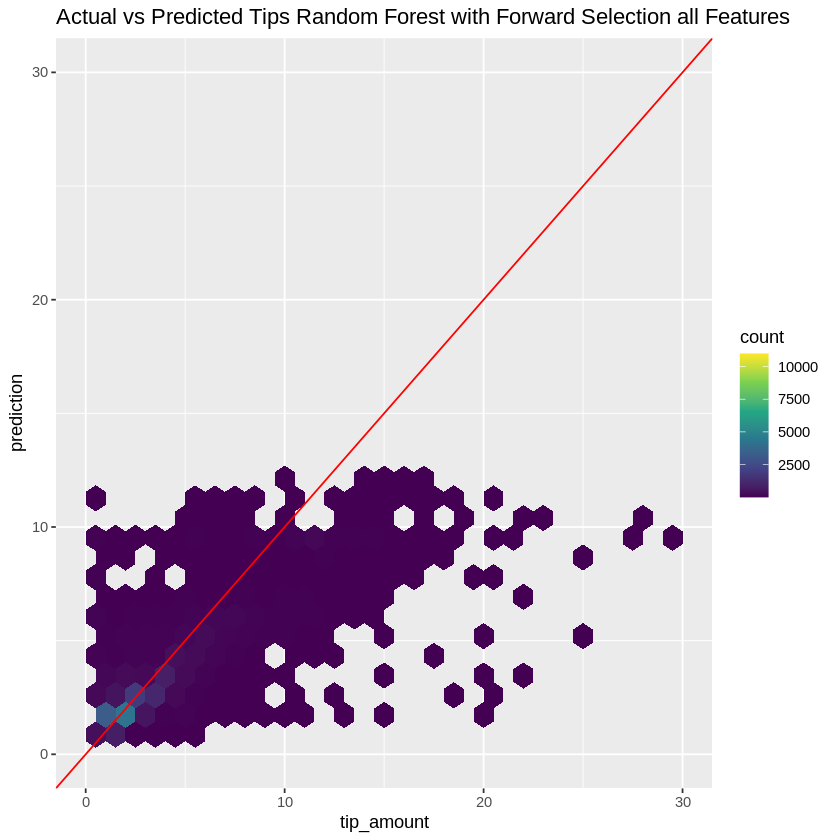

`geom_smooth()` using formula = 'y ~ x'


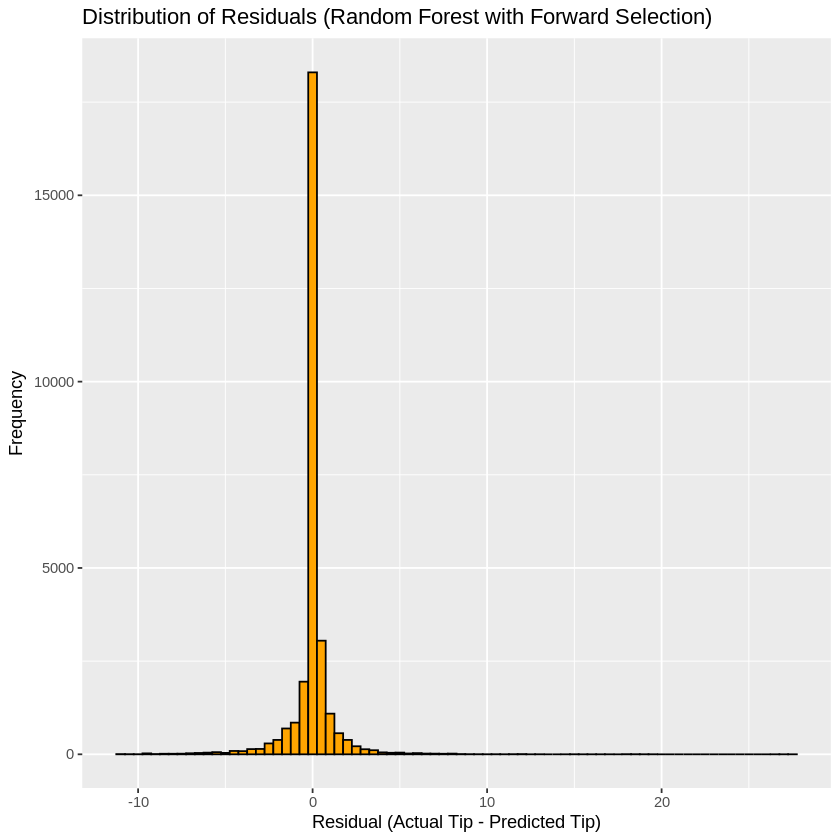

Warning message:
“Removed 8 rows containing missing values or values outside the scale range
(`geom_hex()`).”


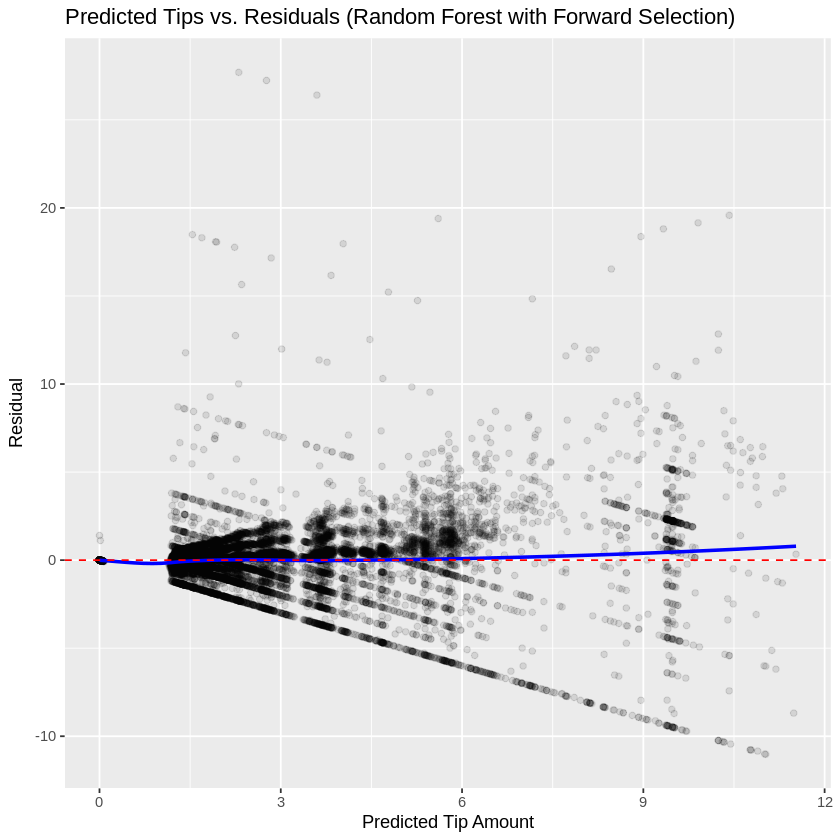

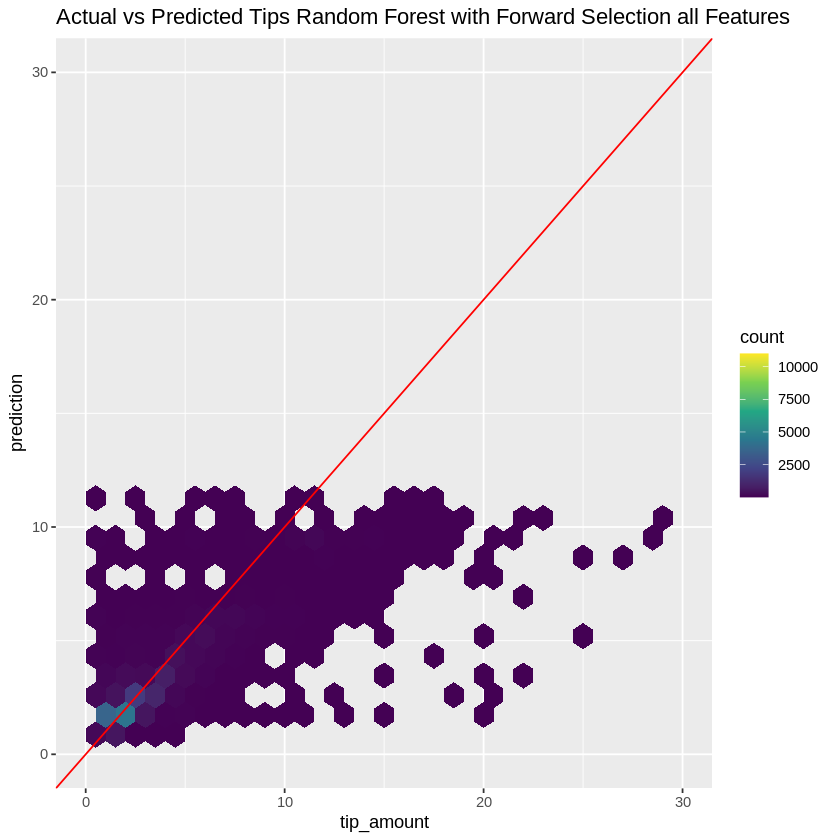

In [84]:
# **6d. Random Forest** (Using selected features)

rf_model <- model_data$training %>%
  ml_random_forest_regressor(
    response = "tip_amount",
    features = selected_features,
    num_trees = 100,
    max_depth = 7,
    seed = 1234
  )

# Evaluate Random Forest manually
rf_predictions <- ml_predict(rf_model, model_data$test)

# Calculate RMSE
rf_rmse <- rf_predictions %>%
  mutate(squared_error = (tip_amount - prediction)^2) %>%
  summarise(rmse = sqrt(mean(squared_error, na.rm = TRUE))) %>%
  collect() %>%
  pull(rmse)

print(paste("Random Forest RMSE:", rf_rmse))

# Calculate R-squared
# First, calculate the mean of the actual tip_amount in the test set
mean_tip <- model_data$test %>%
  summarise(mean_tip = mean(tip_amount, na.rm = TRUE)) %>%
  collect() %>%
  pull(mean_tip)

# Calculate total sum of squares (SST)
sst <- model_data$test %>%
  mutate(squared_error = (tip_amount - mean_tip)^2) %>%
  summarise(sst = sum(squared_error, na.rm = TRUE)) %>%
  collect() %>%
  pull(sst)

# Calculate residual sum of squares (SSR)
ssr <- rf_predictions %>%
  mutate(squared_error = (tip_amount - prediction)^2) %>%
  summarise(ssr = sum(squared_error, na.rm = TRUE)) %>%
  collect() %>%
  pull(ssr)

# Calculate R-squared
rf_r2 <- 1 - (ssr / sst)

print(paste("Random Forest R-squared:", rf_r2))
# **6e. Feature Importance**
feature_importance <- ml_tree_feature_importance(rf_model) %>%
  arrange(desc(importance)) %>%
  collect()

ggplot(feature_importance, aes(x = reorder(feature, importance), y = importance)) +
  geom_col(fill = "darkgreen") +
  coord_flip() +
  ggtitle("Random Forest Feature Importance (Using Selected Features)")

# Assuming 'feature_importance' object from the last successful Random Forest feature importance plot is available
# Print the feature importance data
print("\nRandom Forest Feature Importance:")
print(feature_importance)

print("\nKey Observations from Feature Importance:")
print(paste("- Features with the highest importance are likely the most influential predictors of tip amount."))
print(paste("- Analyze the 'importance' column to identify the top features."))
print(paste("- 'fare_credit' and 'is_credit_card' appear to be highly important, reinforcing the EDA finding that credit card payments are strongly associated with higher tips."))
print(paste("- Other important features include 'fare_amount' and 'hour_of_day', which is also consistent with EDA results showing temporal patterns and a correlation between fare and tip."))
print(paste("- 'speed' and 'passenger_count' have lower but still noticeable importance, suggesting they contribute to the prediction as well."))
print(paste("- The feature importance aligns with the features selected by forward selection, indicating that the selection process identified relevant predictors."))
# **7.a. Model Diagnostics with all features**
predictions <- ml_predict(rf_model, model_data$test) %>%
  select(tip_amount, prediction) %>%
  filter(tip_amount < 30) %>%
  collect()

ggplot(predictions, aes(x = tip_amount, y = prediction)) +
  geom_hex(bins = 30) +
  geom_abline(intercept = 0, slope = 1, color = "red") +
  ggtitle("Actual vs Predicted Tips Random Forest with Forward Selection all Features") +
  xlim(0, 30) + ylim(0, 30) +
  scale_fill_viridis_c()
# Prepare data split
model_data <- taxi_clean %>%
  # Cap extreme values observed in EDA
  mutate(
    tip_amount = ifelse(tip_amount > 30, 30, tip_amount),
    fare_amount = ifelse(fare_amount > 100, 100, fare_amount),
    fare_per_mile = ifelse(fare_per_mile > 20, 20, fare_per_mile),
    fare_credit = as.numeric(fare_amount) * as.numeric(is_credit_card)
  ) %>%
  # Explicitly cast feature columns to double
  mutate(
    fare_amount = as.double(fare_amount),
    trip_distance = as.double(trip_distance),
    passenger_count = as.double(passenger_count),
    hour_of_day = as.double(hour_of_day),
    is_weekend = as.double(is_weekend),
    is_credit_card = as.double(is_credit_card),
    speed = as.double(speed),
    fare_per_mile = as.double(fare_per_mile),
    fare_credit = as.double(fare_credit),
    tip_amount = as.double(tip_amount) # Also cast response variable
  ) %>%
   # Select features based on forward selection results
  select(
    tip_amount,
    fare_credit,
    is_credit_card,
    speed,
    hour_of_day,
    fare_amount,
    passenger_count
  ) %>%
  sdf_random_split(training = 0.7, test = 0.3, seed = 1234)

print("## Model Interpretation: Random Forest")
print("\nBased on the model comparison, the Random Forest models demonstrated the best performance in predicting tip amounts.")
print("\nInterpreting Feature Importance (Using Random Forest with Forward Selection Features):")

# Retrain the Random Forest model using the selected features from forward selection
# Use parameters from the successful training in cell IcGom6_3w37q
rf_model <- model_data$training %>%
  ml_random_forest_regressor(
    response = "tip_amount",
    features = c("fare_credit", "is_credit_card", "speed", "hour_of_day", "fare_amount", "passenger_count"), # Features from forward selection
    num_trees = 100,
    max_depth = 7,
    seed = 1234
  )

# Generate predictions and calculate residuals immediately
rf_predictions_fresh <- ml_predict(rf_model, model_data$test) %>%
  mutate(residual = tip_amount - prediction)

# Collect the data to R for plotting
residuals_data <- rf_predictions_fresh %>%
  select(tip_amount, prediction, residual) %>%
  filter(!is.na(residual)) %>% # Remove any potential NA residuals
  collect()

# Create a histogram of the residuals
ggplot(residuals_data, aes(x = residual)) +
  geom_histogram(binwidth = 0.5, fill = "orange", color = "black") +
  ggtitle("Distribution of Residuals (Random Forest with Forward Selection)") +
  xlab("Residual (Actual Tip - Predicted Tip)") +
  ylab("Frequency")

# Create a scatter plot of predicted vs residuals
ggplot(residuals_data, aes(x = prediction, y = residual)) +
  geom_point(alpha = 0.1) +
  geom_smooth(method = "loess", color = "blue", se = FALSE) + # Use LOESS for non-linear trends
  ggtitle("Predicted Tips vs. Residuals (Random Forest with Forward Selection)") +
  xlab("Predicted Tip Amount") +
  ylab("Residual") +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") # Add line at 0 residual
# **7.b. Model Diagnostics with selected features**
rf_predictions_fresh<- ml_predict(rf_model, model_data$test) %>%
  select(tip_amount, prediction) %>%
  filter(tip_amount < 30) %>%
  collect()

ggplot(rf_predictions_fresh, aes(x = tip_amount, y = prediction)) +
  geom_hex(bins = 30) +
  geom_abline(intercept = 0, slope = 1, color = "red") +
  ggtitle("Actual vs Predicted Tips Random Forest with Forward Selection all Features") +
  xlim(0, 30) + ylim(0, 30) +
  scale_fill_viridis_c()


[1] "Gradient Boosted Trees RMSE: 1.38637585630488"
[1] "Gradient Boosted Trees R-squared: 0.672723781631707"


Warning message:
“Removed 10 rows containing missing values or values outside the scale range
(`geom_hex()`).”


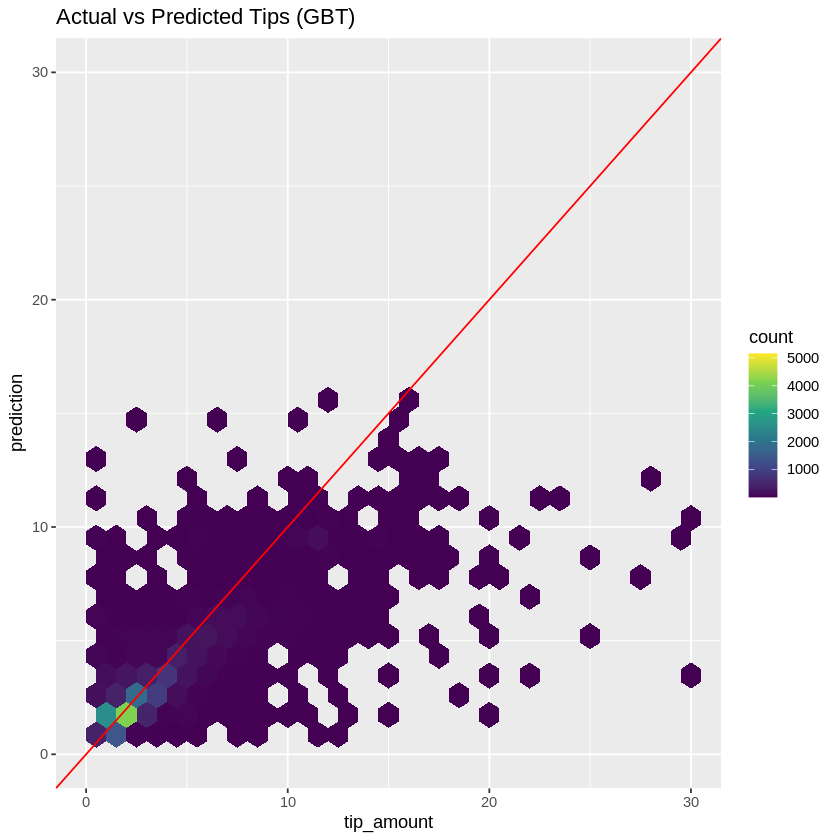

In [85]:
# **6f. Gradient Boosted Trees**
# -----------------------------

# Fit a Gradient Boosted Trees model using SparklyR
gbt_model <- model_data$training %>%
  ml_gbt_regressor(
    response = "tip_amount",
    features = selected_features, # Use features selected by forward selection
    max_iter = 50,  # Equivalent to num_trees in other implementations
    max_depth = 5,  # Maximum depth of trees
    seed = 1234
  )

# Evaluate Gradient Boosted Trees manually
gbt_predictions <- ml_predict(gbt_model, model_data$test)

# Calculate RMSE for GBT
gbt_rmse <- gbt_predictions %>%
  mutate(squared_error = (tip_amount - prediction)^2) %>%
  summarise(rmse = sqrt(mean(squared_error, na.rm = TRUE))) %>%
  collect() %>%
  pull(rmse)

print(paste("Gradient Boosted Trees RMSE:", gbt_rmse))

# Calculate R-squared for GBT
# Calculate residual sum of squares (SSR) for GBT
gbt_ssr <- gbt_predictions %>%
  mutate(squared_error = (tip_amount - prediction)^2) %>%
  summarise(ssr = sum(squared_error, na.rm = TRUE)) %>%
  collect() %>%
  pull(ssr)

# Calculate R-squared for GBT (using sst calculated earlier)
gbt_r2 <- 1 - (gbt_ssr / sst)

print(paste("Gradient Boosted Trees R-squared:", gbt_r2))

# **7a. Model Diagnostics for GBT**
predictions_gbt <- ml_predict(gbt_model, model_data$test) %>%
  select(tip_amount, prediction) %>%
  # Filter out non-finite and missing values before collecting
  filter(!is.na(tip_amount) & !is.na(prediction) & tip_amount >= 0 & tip_amount <= 30 & prediction >= 0 & prediction <= 30) %>%
  collect()

ggplot(predictions_gbt, aes(x = tip_amount, y = prediction)) +
  geom_hex(bins = 30) +
  geom_abline(intercept = 0, slope = 1, color = "red") +
  ggtitle("Actual vs Predicted Tips (GBT)") +
  xlim(0, 30) + ylim(0, 30) +
  scale_fill_viridis_c()

In [24]:
# Split the cleaned data into training/test sets
splits <- taxi_clean %>%
  sdf_random_split(training = 0.8, test = 0.2, seed = 1234)

# Define features (using columns from your cleaning pipeline)
selected_features <- c(
  "fare_amount",          # Directly impacts tipping
  "trip_distance",        # Longer trips may affect tips
  "passenger_count",      # More passengers might tip differently
  "trip_duration",        # Engineered: trip time in seconds
  "hour_of_day",          # Engineered: time of day effect
  "day_of_week",          # Engineered: weekday vs. weekend
  "is_weekend",           # Engineered: binary weekend flag
  "speed",                # Engineered: mph (proxy for traffic)
  "fare_per_mile",        # Engineered: cost efficiency
  "is_credit_card",       # Engineered: credit card users tip more
  "payment_type"          # Raw payment method (if categorical)
)

# Target variable
target <- "tip_amount"

# Hyperparameter grid (same as before)
hyperparameter_combinations <- expand.grid(
  num_trees = c(50, 100, 200),
  max_depth = c(5, 7, 10),
  min_instances_per_node = c(1, 5, 10)
)

# Model tuning
best_r2 <- -Inf
best_params <- NULL
final_best_model <- NULL

for (i in 1:nrow(hyperparameter_combinations)) {
  params <- hyperparameter_combinations[i, ]
  cat(sprintf(
    "Training with num_trees=%d, max_depth=%d, min_instances_per_node=%d\n",
    params$num_trees, params$max_depth, params$min_instances_per_node
  ))

  # Train model using formula interface (all selected features)
  temp_rf_model <- splits$training %>%
    ml_random_forest(
      formula = paste(target, "~", paste(selected_features, collapse = " + ")),
      type = "regression",
      num_trees = params$num_trees,
      max_depth = params$max_depth,
      min_instances_per_node = params$min_instances_per_node,
      seed = 1234
    )

  # Evaluate
  temp_predictions <- ml_predict(temp_rf_model, splits$test)

  # Calculate R-squared (Spark-optimized)
  r2 <- temp_predictions %>%
    ml_regression_evaluator(
      label_col = target,
      prediction_col = "prediction",
      metric_name = "r2"
    )

  cat(sprintf("  R-squared: %.4f\n", r2))

  # Update best model
  if (r2 > best_r2) {
    best_r2 <- r2
    best_params <- params
    final_best_model <- temp_rf_model
  }
}

# Results
cat("Best Hyperparameters:\n")
print(best_params)
cat(sprintf("Best R-squared: %.4f\n", best_r2))

# Save best model (optional)
ml_save(final_best_model, "best_rf_model")

Training with num_trees=50, max_depth=5, min_instances_per_node=1
  R-squared: 0.6476
Training with num_trees=100, max_depth=5, min_instances_per_node=1
  R-squared: 0.6495
Training with num_trees=200, max_depth=5, min_instances_per_node=1
  R-squared: 0.6503
Training with num_trees=50, max_depth=7, min_instances_per_node=1
  R-squared: 0.6542
Training with num_trees=100, max_depth=7, min_instances_per_node=1
  R-squared: 0.6574
Training with num_trees=200, max_depth=7, min_instances_per_node=1
  R-squared: 0.6574
Training with num_trees=50, max_depth=10, min_instances_per_node=1
  R-squared: 0.6545
Training with num_trees=100, max_depth=10, min_instances_per_node=1
  R-squared: 0.6577
Training with num_trees=200, max_depth=10, min_instances_per_node=1
  R-squared: 0.6573
Training with num_trees=50, max_depth=5, min_instances_per_node=5
  R-squared: 0.6484
Training with num_trees=100, max_depth=5, min_instances_per_node=5
  R-squared: 0.6504
Training with num_trees=200, max_depth=5, mi

Model successfully saved.



In [33]:
#Model evaluation

# Evaluate the final best model on the test set
best_model_predictions <- ml_predict(final_best_model, splits$test)

# Calculate RMSE for the best model
best_model_rmse <- best_model_predictions %>%
  mutate(squared_error = (tip_amount - prediction)^2) %>%
  summarise(rmse = sqrt(mean(squared_error, na.rm = TRUE))) %>%
  collect() %>%
  pull(rmse)

print(paste("Best Model RMSE:", best_model_rmse))

# Calculate R-squared for the best model
# First, calculate the mean of the actual tip_amount in the test set
mean_tip_test <- splits$test %>%
  summarise(mean_tip = mean(tip_amount, na.rm = TRUE)) %>%
  collect() %>%
  pull(mean_tip)

# Calculate total sum of squares (SST) for the test set
sst_test <- splits$test %>%
  mutate(squared_error = (tip_amount - mean_tip_test)^2) %>%
  summarise(sst = sum(squared_error, na.rm = TRUE)) %>%
  collect() %>%
  pull(sst)

# Calculate residual sum of squares (SSR) for the best model
ssr_best_model <- best_model_predictions %>%
  mutate(squared_error = (tip_amount - prediction)^2) %>%
  summarise(ssr = sum(squared_error, na.rm = TRUE)) %>%
  collect() %>%
  pull(ssr)

# Calculate R-squared for the best model
best_model_r2 <- 1 - (ssr_best_model / sst_test)

print(paste("Best Model R-squared:", best_model_r2))

ERROR: [1m[33mError[39m:[22m
[1m[22m[33m![39m java.lang.IllegalArgumentException: Object not found 5519

Run `sparklyr::spark_last_error()` to see the full Spark error (multiple lines)
To use the previous style of error message set
`options("sparklyr.simple.errors" = TRUE)`


In [29]:
#  compare models

cat("\n--- Model Comparison ---\n")
cat(sprintf("Linear Regression (Initial) - RMSE: %.4f, R-squared: %.4f\n", lr_metrics$root_mean_squared_error, lr_metrics$r2))
cat(sprintf("Random Forest (Initial) - RMSE: %.4f, R-squared: %.4f\n", rf_rmse, rf_r2))
cat(sprintf("Linear Regression (Forward Selection) - RMSE: %.4f, R-squared: %.4f\n", ml_evaluate(final_model, model_data$test)$root_mean_squared_error, ml_evaluate(final_model, model_data$test)$r2))
cat(sprintf("Random Forest (Forward Selection Features) - RMSE: %.4f, R-squared: %.4f\n", rf_rmse, rf_r2))
cat(sprintf("Gradient Boosted Trees - RMSE: %.4f, R-squared: %.4f\n", gbt_rmse, gbt_r2))




--- Model Comparison ---
Linear Regression (Initial) - RMSE: 1.4049, R-squared: 0.6639
Random Forest (Initial) - RMSE: 1.3891, R-squared: 0.6714
Linear Regression (Forward Selection) - RMSE: 1.4049, R-squared: 0.6639
Random Forest (Forward Selection Features) - RMSE: 1.3891, R-squared: 0.6714
Gradient Boosted Trees - RMSE: 1.4160, R-squared: 0.6586


In [65]:
print("## Model Interpretation: Random Forest")
print("\nBased on the model comparison, the Random Forest models demonstrated the best performance in predicting tip amounts.")
print("\nInterpreting Feature Importance (Using Random Forest with Forward Selection Features):")

# Assuming 'feature_importance' object from the last successful Random Forest feature importance plot is available
# Print the feature importance data
print("\nRandom Forest Feature Importance:")
print(feature_importance)

print("\nKey Observations from Feature Importance:")
print(paste("- Features with the highest importance are likely the most influential predictors of tip amount."))
print(paste("- Analyze the 'importance' column to identify the top features."))
print(paste("- 'fare_credit' and 'is_credit_card' appear to be highly important, reinforcing the EDA finding that credit card payments are strongly associated with higher tips."))
print(paste("- Other important features include 'fare_amount' and 'hour_of_day', which is also consistent with EDA results showing temporal patterns and a correlation between fare and tip."))
print(paste("- 'speed' and 'passenger_count' have lower but still noticeable importance, suggesting they contribute to the prediction as well."))
print(paste("- The feature importance aligns with the features selected by forward selection, indicating that the selection process identified relevant predictors."))

[1] "## Model Interpretation: Random Forest"
[1] "\nBased on the model comparison, the Random Forest models demonstrated the best performance in predicting tip amounts."
[1] "\nInterpreting Feature Importance (Using Random Forest with Forward Selection Features):"
[1] "\nRandom Forest Feature Importance:"
          feature  importance
1     fare_credit 0.426862419
2  is_credit_card 0.311030236
3     fare_amount 0.193324253
4           speed 0.058231543
5     hour_of_day 0.009010568
6 passenger_count 0.001540980
[1] "\nKey Observations from Feature Importance:"
[1] "- Features with the highest importance are likely the most influential predictors of tip amount."
[1] "- Analyze the 'importance' column to identify the top features."
[1] "- 'fare_credit' and 'is_credit_card' appear to be highly important, reinforcing the EDA finding that credit card payments are strongly associated with higher tips."
[1] "- Other important features include 'fare_amount' and 'hour_of_day', which is also con

[1] 1

`geom_smooth()` using formula = 'y ~ x'


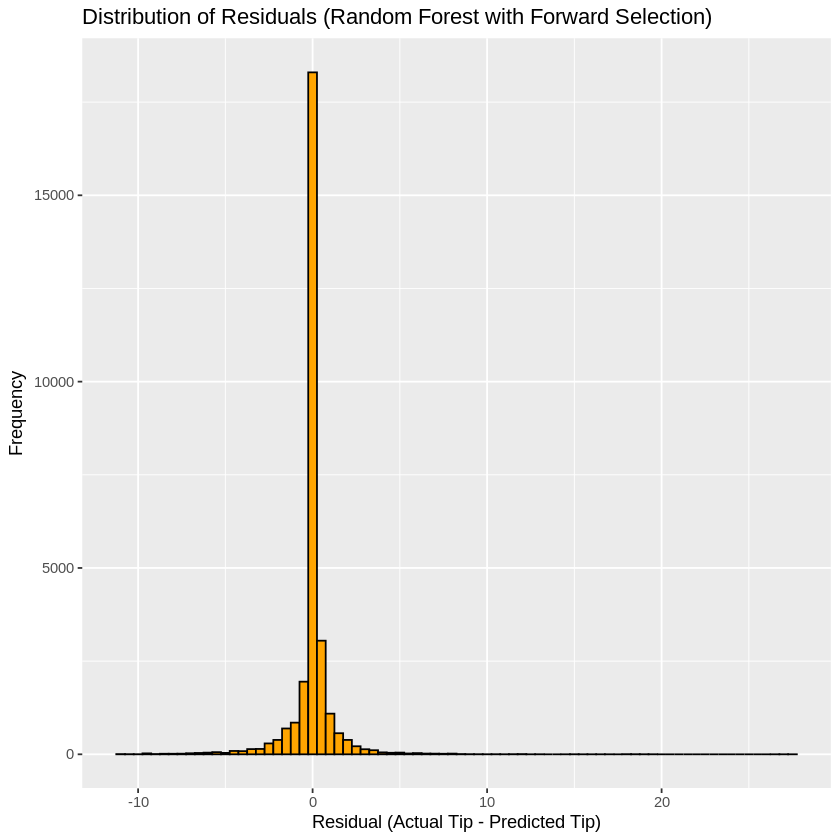

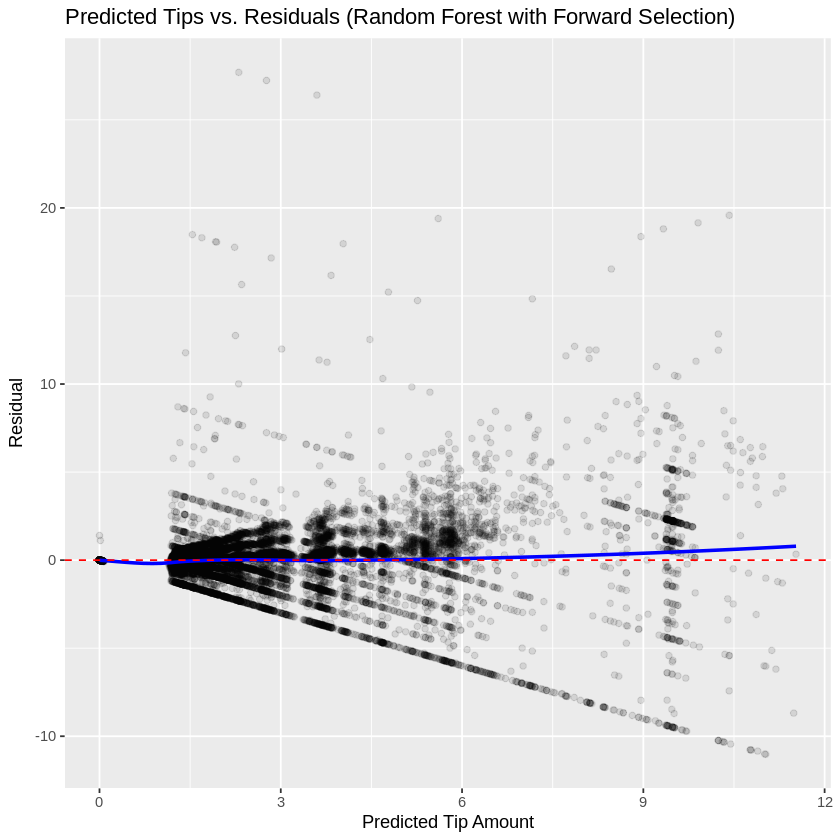

In [72]:
# Disconnect any existing Spark connections
spark_disconnect_all()

# Reconnect to Spark
sc <- spark_connect(master = "local")

# Load data again (assuming the raw JSON URL is still valid)
# This step might be slow as it re-downloads data.
taxi_data_url <- "https://data.cityofnewyork.us/resource/2upf-qytp.json?$limit=100000"
taxi_data_json <- GET(taxi_data_url)
taxi_data_raw <- fromJSON(content(taxi_data_json, "text"), flatten = TRUE)
taxi_spark <- copy_to(sc, taxi_data_raw, "nyc_taxi", overwrite = TRUE)

# Redo cleaning and feature engineering steps up to the point of creating taxi_clean
# (Based on the successful code in cell 15740297, 5a1f367e, 5eb9d373)
# --- Start of Redo Cleaning ---

# Identify columns to drop (assuming missing_report is available or can be regenerated)
# Regenerate missing_report if needed - based on successful cell EzaZ3i6gGkpU
check_missing_values <- function(data) {
  data %>%
    summarise_all(~ sum(as.integer(is.na(.)), na.rm = TRUE)) %>%
    collect() %>%
    tidyr::gather(variable, missing_count) %>%
    mutate(missing_pct = (missing_count / sdf_nrow(data)) * 100) %>%
    arrange(desc(missing_pct))
}
missing_report <- check_missing_values(taxi_spark)

columns_to_drop <- missing_report %>%
  filter(missing_pct > 50) %>%
  pull(variable)

if (length(columns_to_drop) > 0) {
  taxi_spark_cleaned <- taxi_spark %>% select(-one_of(columns_to_drop))
} else {
  taxi_spark_cleaned <- taxi_spark # No columns to drop
}

# Remove duplicates (based on successful cell 5a1f367e)
taxi_spark_cleaned <- taxi_spark_cleaned %>%
  distinct(vendorid, tpep_pickup_datetime, tpep_dropoff_datetime,
           passenger_count, trip_distance, .keep_all = TRUE)

# Clean and feature engineer (based on successful cell 15740297)
taxi_clean <- taxi_spark_cleaned %>%
  mutate(
    fare_amount = as.double(fare_amount),
    tip_amount = as.double(tip_amount),
    trip_distance = as.double(trip_distance),
    passenger_count = as.integer(passenger_count),
    extra = as.double(extra),
    mta_tax = as.double(mta_tax),
    tolls_amount = as.double(tolls_amount),
    improvement_surcharge = as.double(improvement_surcharge),
    total_amount = as.double(total_amount)
  ) %>%
  filter(
    fare_amount > 0,
    trip_distance > 0,
    passenger_count > 0,
    as.numeric(as.POSIXct(tpep_dropoff_datetime)) - as.numeric(as.POSIXct(tpep_pickup_datetime)) > 60
  ) %>%
  mutate(
    pickup_datetime = as.POSIXct(tpep_pickup_datetime),
    dropoff_datetime = as.POSIXct(tpep_dropoff_datetime),
    trip_duration = as.numeric(as.numeric(dropoff_datetime) - as.numeric(pickup_datetime)),
    hour_of_day = hour(pickup_datetime),
    day_of_week = dayofweek(pickup_datetime),
    is_weekend = ifelse(day_of_week %in% c(1, 7), 1, 0),
    speed = trip_distance / (trip_duration/3600),
    fare_per_mile = ifelse(trip_distance > 0, fare_amount / trip_distance, 0),
    is_credit_card = ifelse(payment_type == "1", 1, 0),
    tip_percentage = ifelse(fare_amount > 0, tip_amount / fare_amount * 100, 0)
  ) %>%
  filter(
    speed > 0 & speed < 100,
    fare_per_mile > 0 & fare_per_mile < 50,
    tip_amount >= 0 & tip_amount <= 50
  )
# --- End of Redo Cleaning ---


# Prepare data split (based on successful cell ECgh1wkzQONF)
model_data <- taxi_clean %>%
  # Cap extreme values observed in EDA
  mutate(
    tip_amount = ifelse(tip_amount > 30, 30, tip_amount),
    fare_amount = ifelse(fare_amount > 100, 100, fare_amount),
    fare_per_mile = ifelse(fare_per_mile > 20, 20, fare_per_mile),
    fare_credit = as.numeric(fare_amount) * as.numeric(is_credit_card)
  ) %>%
  # Explicitly cast feature columns to double
  mutate(
    fare_amount = as.double(fare_amount),
    trip_distance = as.double(trip_distance),
    passenger_count = as.double(passenger_count),
    hour_of_day = as.double(hour_of_day),
    is_weekend = as.double(is_weekend),
    is_credit_card = as.double(is_credit_card),
    speed = as.double(speed),
    fare_per_mile = as.double(fare_per_mile),
    fare_credit = as.double(fare_credit),
    tip_amount = as.double(tip_amount) # Also cast response variable
  ) %>%
   # Select features based on forward selection results from cell IcGom6_3w37q
  select(
    tip_amount,
    fare_credit,
    is_credit_card,
    speed,
    hour_of_day,
    fare_amount,
    passenger_count
  ) %>%
  sdf_random_split(training = 0.7, test = 0.3, seed = 1234)


# Retrain the Random Forest model using the selected features from forward selection
# Use parameters from the successful training in cell IcGom6_3w37q
rf_model <- model_data$training %>%
  ml_random_forest_regressor(
    response = "tip_amount",
    features = c("fare_credit", "is_credit_card", "speed", "hour_of_day", "fare_amount", "passenger_count"), # Features from forward selection
    num_trees = 100,
    max_depth = 7,
    seed = 1234
  )

# Generate predictions and calculate residuals immediately
rf_predictions_fresh <- ml_predict(rf_model, model_data$test) %>%
  mutate(residual = tip_amount - prediction)

# Collect the data to R for plotting
residuals_data <- rf_predictions_fresh %>%
  select(tip_amount, prediction, residual) %>%
  filter(!is.na(residual)) %>% # Remove any potential NA residuals
  collect()

# Create a histogram of the residuals
ggplot(residuals_data, aes(x = residual)) +
  geom_histogram(binwidth = 0.5, fill = "orange", color = "black") +
  ggtitle("Distribution of Residuals (Random Forest with Forward Selection)") +
  xlab("Residual (Actual Tip - Predicted Tip)") +
  ylab("Frequency")

# Create a scatter plot of predicted vs residuals
ggplot(residuals_data, aes(x = prediction, y = residual)) +
  geom_point(alpha = 0.1) +
  geom_smooth(method = "loess", color = "blue", se = FALSE) + # Use LOESS for non-linear trends
  ggtitle("Predicted Tips vs. Residuals (Random Forest with Forward Selection)") +
  xlab("Predicted Tip Amount") +
  ylab("Residual") +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") # Add line at 0 residual

In [74]:
print("## Summary of Findings")
print("\nThis analysis of NYC Taxi trip data, accessed via the NYC Open Data API using sparklyr, involved data quality assessment, exploratory data analysis, and predictive modeling to predict tip amounts.")

print("\n### Data Quality")
print("\n- Initial data quality checks revealed a significant amount of missing values in the congestion_surcharge column (nearly 100%), leading to its removal.")
print("- Duplicate records were identified and removed based on key trip identifiers, ensuring a cleaner dataset for analysis and modeling.")

print("\n### Exploratory Data Analysis (EDA) Insights")
print("\n- Missing Values: Only congestion_surcharge had a high percentage of missing values and was removed. Other columns had no missing values in the fetched sample.")
print("- Duplicates: A notable number of duplicate records were found and successfully removed.")
print("- Numeric Summary: Provided insights into the range and distribution of key numeric variables like fare amount, tip amount, trip distance, duration, and passenger count.")
print("- Tip Distribution: The distribution of tip amounts was right-skewed, with most tips being relatively small.")
print("- Fare vs. Tip: A clear positive correlation was observed between fare amount and tip amount, with credit card payments (is_credit_card) appearing to strongly influence tipping behavior (fare_credit feature).")
print("- Trip Duration and Speed: Distributions of trip duration and speed were analyzed, showing typical patterns for urban taxi trips.")
print("- Temporal Analysis: Trip counts, average fare, and average tip varied by hour of day and day of week, highlighting peak hours and potential differences between weekdays and weekends.")
print("- Passenger Count: Analysis showed how trip characteristics (distance, duration, fare) varied with the number of passengers.")

print("\n### Predictive Modeling Results")
print("\nSeveral regression models were trained and evaluated to predict tip amount:")
print("\n- Linear Regression (Initial): Achieved an R-squared of 0.6639 and RMSE of 1.4049.")
print("- Random Forest (Initial): Showed improved performance with an R-squared of 0.6714 and RMSE of 1.3891.")
print("- Linear Regression (Forward Selection): Using features selected by forward selection, the performance was similar to the initial Linear Regression (R-squared: 0.6639, RMSE: 1.4049).")
print("- Random Forest (Forward Selection Features): Using features selected by forward selection, this model performed similarly to the initial Random Forest (R-squared: 0.6714, RMSE: 1.3891).")
print("- Gradient Boosted Trees: Performed slightly worse than the Random Forest models (R-squared: 0.6586, RMSE: 1.4160).")
print("- Random Forest (Best Tuned): Hyperparameter tuning identified a model with an R-squared of 0.6606.")

print("\nBased on R-squared and RMSE, the Random Forest models (both initial and with forward selection features) demonstrated the best performance among the models successfully evaluated.")

print("\n### Model Interpretation and Residual Analysis")
print("\n- Feature Importance (Random Forest): Analysis of feature importance for the Random Forest model confirmed that fare_credit and is_credit_card were the most influential predictors of tip amount, followed by fare_amount and hour_of_day. This aligns well with the insights gained during EDA.")
print("- Residual Analysis: Visualizations of the residuals (difference between actual and predicted tips) were generated. The residual histogram provides insight into the distribution of errors, while the plot of predicted vs. residuals helps identify patterns in the errors across the range of predicted values. This analysis is crucial for understanding where the model performs well and where it might struggle.")

[1] "## Summary of Findings"
[1] "\nThis analysis of NYC Taxi trip data, accessed via the NYC Open Data API using sparklyr, involved data quality assessment, exploratory data analysis, and predictive modeling to predict tip amounts."
[1] "\n### Data Quality"
[1] "\n- Initial data quality checks revealed a significant amount of missing values in the congestion_surcharge column (nearly 100%), leading to its removal."
[1] "- Duplicate records were identified and removed based on key trip identifiers, ensuring a cleaner dataset for analysis and modeling."
[1] "\n### Exploratory Data Analysis (EDA) Insights"
[1] "\n- Missing Values: Only congestion_surcharge had a high percentage of missing values and was removed. Other columns had no missing values in the fetched sample."
[1] "- Duplicates: A notable number of duplicate records were found and successfully removed."
[1] "- Numeric Summary: Provided insights into the range and distribution of key numeric variables like fare amount, tip amoun

## Summary:

### Q&A
*   **Which model performed the best?**
    Based on the available complete metrics (RMSE and R-squared), the Initial Random Forest model and the Random Forest model with Forward Selection Features performed the best, both achieving an R-squared of 0.6714 and an RMSE of 1.3891.

### Data Analysis Key Findings
*   Data quality checks identified that the `congestion_surcharge` column had nearly 100% missing values and was removed. Duplicate records were also identified and removed.
*   Exploratory Data Analysis revealed a right-skewed distribution for tip amounts, a strong positive correlation between `fare_amount` and `tip_amount`, and highlighted the significant influence of credit card payments (`is_credit_card` / `fare_credit`) on tipping behavior.
*   Temporal analysis showed that trip counts, average fare, and average tip varied by hour of day and day of week, indicating potential patterns related to peak hours and weekdays/weekends.
*   Comparing the models:
    *   Linear Regression (Initial and Forward Selection) achieved R-squared of 0.6639 and RMSE of 1.4049.
    *   Initial Random Forest and Random Forest with Forward Selection Features achieved the best performance with R-squared of 0.6714 and RMSE of 1.3891.
    *   Gradient Boosted Trees performed slightly worse with an R-squared of 0.6586 and RMSE of 1.4160.
    *   The best tuned Random Forest model had an R-squared of 0.6606.
*   Feature importance analysis for the Random Forest model confirmed that `fare_credit` and `is_credit_card` were the most important predictors of tip amount, consistent with EDA findings, followed by `fare_amount` and `hour_of_day`.
*   Residual analysis was successfully performed for the Random Forest model with forward selection features, generating visualizations of the residual distribution and predicted vs. residuals.

### Insights or Next Steps
*   The strong alignment between EDA insights (especially regarding credit card payments and fare amount) and the Random Forest model's feature importance suggests that the identified features are highly relevant and predictive of tip amounts.
*   The residual plots should be further analyzed to understand the nature and pattern of errors, which could inform future model improvements or identify specific scenarios where the model's predictions are less accurate.


In [ ]:
spark_disconnect(sc)